# Task II: Classical Graph Neural Network (GNN) 

For Task II, you will use ParticleNet’s data for Quark/Gluon jet classification available here with its corresponding description:
- Choose 2 Graph-based architectures of your choice to classify jets as being quarks or gluons. Provide a description on what considerations you have taken to project this point-cloud dataset to a set of interconnected nodes and edges. 
- Discuss the resulting performance of the 2 chosen architectures. 


In [1]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, Linear, BatchNorm1d
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

import torch_geometric as geom
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data
import torch_geometric.loader as geom_loader
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_add_pool

import os 
import numpy as np
from tqdm import tqdm, trange
from datetime import datetime
import networkx as nx
from torchmetrics import AUROC
import matplotlib.pyplot as plt
from timeit import default_timer as timer
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
import seaborn as sns

torch.__version__

'2.2.1+cu121'

In [2]:
np.random.seed(2024)
torch.manual_seed(2024)
device = "cuda" if torch.cuda.is_available() else "cpu"

Projections are such that node characteristics encompass key attributes such as pt, rapidity, azimuthal angle, and pdgid. The global aspect of the graph corresponds to the jet's classification label, distinguishing between gluon (0) and quark (1). Prior to utilization, features undergo preprocessing procedures including jet centering and pt normalization, as outlined in [this](https://arxiv.org/abs/1810.05165) paper. Bidirectional edges are established between nodes if they are adjacent based on pt, rapidity, and azimuthal angle, ensuring no isolated nodes within the graph structure.

In [3]:
class JetDataset(geom_data.Dataset):
    
    def __init__(self, root, filename, stop = None, test=False, transform=None, pre_transform=None):
        self.test = test
        self.filename = filename
        self.stop = stop
        super(JetDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        return self.filename

    @property
    def processed_file_names(self):
        print('processed_file_names', self.raw_paths)
        self.data = np.load(self.raw_paths[0], allow_pickle=True)
        self.n_graphs = min(self.stop, self.data['X'].shape[0]) if self.stop else self.data['X'].shape[0]
        if self.test:
            return [f'data_test_{i}.pt' for i in range(self.n_graphs)]
        else:
            return [f'data_{i}.pt' for i in range(self.n_graphs)]

    def download(self):
        pass

    def process(self):
        self.data = np.load(self.raw_paths[0], allow_pickle=True)
        X = self.data['X']
        y = self.data['y']
        
        # https://github.com/pkomiske/EnergyFlow/blob/master/energyflow/utils/data_utils.py
        PID2FLOAT_MAP = {22: 0,
                    211: .1, -211: .2,
                    321: .3, -321: .4,
                    130: .5,
                    2112: .6, -2112: .7,
                    2212: .8, -2212: .9,
                    11: 1.0, -11: 1.1,
                    13: 1.2, -13: 1.3,
                    0: 0,}
        pids = np.unique(X[:, :, 3].flatten())
        for pid in tqdm(pids):
            np.place(X[:, :, 3], X[:, :, 3] == pid, PID2FLOAT_MAP[pid])
            
        for i in tqdm(range(self.n_graphs)):
            # Processing as per standard procedures:
            jet_data = X[i]
            jet_label = y[i]
            _jet_data = jet_data[~np.all(jet_data == 0, axis = 1)] 
            yphi_avg = np.average(_jet_data[:,1:3], weights=_jet_data[:,0], axis=0)
            _jet_data[:,1:3] -= yphi_avg
            _jet_data[:, 0] /= np.sum(_jet_data[:, 0])
            _jet_data = _jet_data[_jet_data[:,0].argsort()][::-1].copy()
            
            # node features
            node_feats = self._get_node_features(_jet_data)
            
            # adjacency info
            edge_index = self._get_adjacency_info(_jet_data)
            
            # labels info
            label = self._get_labels(jet_label)
            
    
            data = geom_data.Data(x=node_feats, 
                        edge_index=edge_index,
                        y=label)
            
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_test_{i}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                 f'data_{i}.pt'))


    def _get_node_features(self, jet_data):
        return torch.tensor(jet_data, dtype=torch.float)

    def _get_adjacency_info(self, jet_data):
        """
        We could also use rdmolops.GetAdjacencyMatrix(mol)
        but we want to be sure that the order of the indices
        matches the order of the edge features
        """
        pt_order = jet_data[:,0].argsort()[::-1]
        rapidity_order = jet_data[:,1].argsort()[::-1]
        eta_order = jet_data[:,2].argsort()[::-1]
        in_node  = np.concatenate((pt_order[:-1], rapidity_order[:-1], eta_order[:-1]))
        out_node = np.concatenate((pt_order[1: ], rapidity_order[1: ], eta_order[1: ]))
        edge_indices = np.stack((in_node, out_node), axis= 0)
        edge_indices = torch.tensor(edge_indices)
        edge_indices = edge_indices.to(torch.long).view(2, -1)
        edge_indices = geom.utils.to_undirected(edge_indices)
        edge_indices = geom.utils.add_self_loops(edge_indices)[0]
        return edge_indices
       
    def _get_labels(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.n_graphs

    def get(self, idx):
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))   
        return data     

processed_file_names ['/home/rohan/Projects/learning_outcomes/raw/QG_jets.npz']
The dataset instance: JetDataset(100000)
The total number of graphs in the dataset: 100000
The first graph: Data(x=[18, 4], edge_index=[2, 96], y=[1])


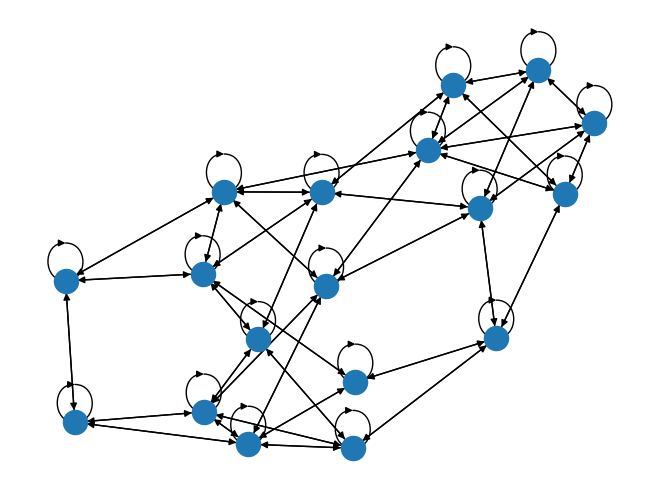

In [4]:
dataset = JetDataset(root = "/home/rohan/Projects/learning_outcomes", filename='QG_jets.npz')

print(f"The dataset instance: {dataset}")
print(f"The total number of graphs in the dataset: {len(dataset)}")
print(f"The first graph: {dataset[0]}")

# Draw the graph
nx.draw(geom.utils.to_networkx(dataset[0]))

In [5]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, (int(0.7*len(dataset)),int(0.15*len(dataset)),int(0.15*len(dataset))))
train_loader = DataLoader(train_set, shuffle=True, batch_size=256,num_workers=8)
val_loader = DataLoader(val_set, shuffle=False, batch_size=256,num_workers=8)
test_loader = DataLoader(test_set, shuffle=False, batch_size=256,num_workers=8)

### The architectures chosen:

After experimenting with various 2-layered Graph Neural Network (GNN) architectures, including those employing GraphSAGE operator, Graph convolutional operator, and Graph Transformer operator, the most favorable outcomes were observed with the utilization of `GATConv` and `GATv2Conv` layers. These layers, as introduced in the papers [here](https://arxiv.org/abs/1710.10903) and [here](https://arxiv.org/abs/2105.14491) respectively, demonstrated superior performance in the context of Quark Gluon classification as seen in the following code.

In [6]:
gnn_layer_by_name = {
    "GAT": geom_nn.GATConv,
    "GATv2": geom_nn.GATv2Conv,
}

In [7]:
class GNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, num_layers=2, layer_name="Gsage", dp_rate=0.1, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of the output features. Usually number of classes in classification
            num_layers - Number of "hidden" graph layers
            layer_name - String of the graph layer to use
            dp_rate - Dropout rate to apply throughout the network
            kwargs - Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers-1):
            layers += [
                gnn_layer(in_channels=in_channels,
                          out_channels=out_channels,
                          **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate)
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels,
                             out_channels=c_out,
                             **kwargs)]
        self.layers = nn.ModuleList(layers)

    def forward(self, x, edge_index):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph 
            (PyTorch geometric notation)
        """
        for l in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.`
            if isinstance(l, geom_nn.MessagePassing):
                x = l(x, edge_index)
            else:
                x = l(x)
        return x

In [8]:
class GraphGNNModel(nn.Module):

    def __init__(self, c_in, c_hidden, c_out, dp_rate_linear=0.5, **kwargs):
        """
        Inputs:
            c_in - Dimension of input features
            c_hidden - Dimension of hidden features
            c_out - Dimension of output features (usually number of classes)
            dp_rate_linear - Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs - Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in,
                            c_hidden=c_hidden,
                            c_out=c_hidden, 
                            **kwargs)
        self.head = nn.Sequential(
            nn.Dropout(dp_rate_linear),
            nn.Linear(c_hidden, c_out)
        )

    def forward(self, x, edge_index, batch_idx):
        """
        Inputs:
            x - Input features per node
            edge_index - List of vertex index pairs representing the edges in the graph 
            (PyTorch geometric notation)
            batch_idx - Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_mean_pool(x, batch_idx) # Average pooling
        x = self.head(x)
        return x

In [9]:
# Training and Validation Loop:
torch.manual_seed(42)
model = GraphGNNModel(c_in = dataset.num_node_features,c_hidden = 16, c_out=1, num_layers=2, layer_name="GAT").to(device)
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.1, weight_decay=0.0)
scheduler = OneCycleLR(optimizer=optimizer, max_lr=0.1,steps_per_epoch=len(train_loader), epochs=150)

train_time_start_on_cpu = timer()
epochs = 150

best_val_acc = 50.
patience = 150
counter = 0

auc_metric_train = AUROC(task="binary")
auc_metric_val = AUROC(task="binary")
history_train_loss = []
history_val_loss = []
history_train_acc = []
history_val_acc = []
history_train_auc =[]
history_val_auc = []

for epoch in trange(epochs, desc="Training"):
    ### Training
    train_loss = 0
    correct, total = 0,0
    model.train()
    auc_metric_train.reset()
    for data in train_loader:
        x, edge_index, batch_idx, y = data.x, data.edge_index, data.batch, data.y
        x, edge_index, batch_idx, y = x.to(device), edge_index.to(device), batch_idx.to(device), y.to(device)
        y_pred = model(x, edge_index, batch_idx)
        loss = loss_fn(y_pred, y.unsqueeze(1).to(torch.float32))
        train_loss += loss.detach().cpu().item()
        correct += torch.sum(y==(y_pred.squeeze() >= 0).float()).detach().cpu().item()
        total += len(y)
        auc_metric_train.update(torch.sigmoid(y_pred.squeeze()), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    train_loss /= len(train_loader)
    train_acc = correct / total * 100
    train_auc = auc_metric_train.compute().detach().cpu().item()
    history_train_loss.append(train_loss) 
    history_train_acc.append(train_acc) 
    history_train_auc.append(train_auc) 

    ### Testing
    val_loss = 0
    correct, total = 0,0
    model.eval()
    auc_metric_val.reset()
    with torch.inference_mode():
        for data in val_loader:
            x, edge_index, batch_idx, y = data.x, data.edge_index, data.batch, data.y
            x, edge_index, batch_idx, y = x.to(device), edge_index.to(device), batch_idx.to(device), y.to(device)
            val_pred = model(x, edge_index, batch_idx)
            loss = loss_fn(val_pred, y.unsqueeze(1).to(torch.float32))
            val_loss += loss.detach().cpu().item()
            correct += torch.sum(y==(val_pred.squeeze() >= 0).float()).detach().cpu().item()
            total += len(y)
            auc_metric_val.update(torch.sigmoid(val_pred.squeeze()), y)

        val_loss /= len(val_loader)
        val_acc = correct / total * 100
        val_auc = auc_metric_val.compute().detach().cpu().item()
        history_val_loss.append(val_loss) 
        history_val_acc.append(val_acc) 
        history_val_auc.append(val_auc) 
        

        # Check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'GNNmodel_1.pth')
            print("\nSaving Best Model...........")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch + 1} as validation accuracy did not increase for {patience} epochs.')
                break


    print(f"\nEpoch: {epoch+1} | lr: {scheduler.optimizer.param_groups[0]['lr']} | train loss: {train_loss:.5f} | val loss: {val_loss:.5f} | train acc.: {train_acc:.5f}% | val acc.: {val_acc:.5f}% | train auc: {train_auc:.5f} | val auc: {val_auc:.5f}")
    print("                            ")

# Calculate training time
train_time_end_on_cpu = timer()
print(f"Time for training: {train_time_end_on_cpu - train_time_start_on_cpu}s")

Training:   1%|▏                                | 1/150 [00:16<40:19, 16.24s/it]


Saving Best Model...........

Epoch: 1 | lr: 0.004116944548162055 | train loss: 0.58209 | val loss: 0.51773 | train acc.: 69.60857% | val acc.: 75.58000% | train auc: 0.77265 | val auc: 0.83057
                            


Training:   1%|▍                                | 2/150 [00:31<38:56, 15.79s/it]


Saving Best Model...........

Epoch: 2 | lr: 0.004467208358175462 | train loss: 0.50964 | val loss: 0.48512 | train acc.: 76.73286% | val acc.: 77.96000% | train auc: 0.83486 | val auc: 0.84896
                            


Training:   2%|▋                                | 3/150 [00:47<38:10, 15.58s/it]


Saving Best Model...........

Epoch: 3 | lr: 0.005049084703248594 | train loss: 0.49289 | val loss: 0.47932 | train acc.: 77.65143% | val acc.: 78.02667% | train auc: 0.84412 | val auc: 0.85294
                            


Training:   3%|▉                                | 4/150 [01:02<37:57, 15.60s/it]


Saving Best Model...........

Epoch: 4 | lr: 0.005859738280620599 | train loss: 0.48866 | val loss: 0.47439 | train acc.: 77.86857% | val acc.: 78.34000% | train auc: 0.84653 | val auc: 0.85440
                            


Training:   3%|█                                | 5/150 [01:18<37:40, 15.59s/it]


Saving Best Model...........

Epoch: 5 | lr: 0.0068952190271113906 | train loss: 0.49036 | val loss: 0.47650 | train acc.: 77.72286% | val acc.: 78.34667% | train auc: 0.84608 | val auc: 0.85451
                            


Training:   4%|█▎                               | 6/150 [01:33<37:03, 15.44s/it]


Epoch: 6 | lr: 0.008150481366553108 | train loss: 0.48388 | val loss: 0.47735 | train acc.: 78.17143% | val acc.: 77.98667% | train auc: 0.85075 | val auc: 0.85689
                            


Training:   5%|█▌                               | 7/150 [01:48<36:36, 15.36s/it]


Epoch: 7 | lr: 0.009619408795316128 | train loss: 0.48952 | val loss: 0.48188 | train acc.: 77.82429% | val acc.: 77.70000% | train auc: 0.84690 | val auc: 0.85688
                            


Training:   5%|█▊                               | 8/150 [02:04<36:44, 15.53s/it]


Saving Best Model...........

Epoch: 8 | lr: 0.01129484368613215 | train loss: 0.48709 | val loss: 0.47188 | train acc.: 77.95286% | val acc.: 78.68667% | train auc: 0.84831 | val auc: 0.85650
                            


Training:   6%|█▉                               | 9/150 [02:20<36:31, 15.55s/it]


Epoch: 9 | lr: 0.01316862216498943 | train loss: 0.48953 | val loss: 0.48556 | train acc.: 77.83857% | val acc.: 77.33333% | train auc: 0.84696 | val auc: 0.85718
                            


Training:   7%|██▏                             | 10/150 [02:35<36:20, 15.58s/it]


Epoch: 10 | lr: 0.01523161389115607 | train loss: 0.49002 | val loss: 0.47649 | train acc.: 77.80143% | val acc.: 78.21333% | train auc: 0.84686 | val auc: 0.85531
                            


Training:   7%|██▎                             | 11/150 [02:50<35:18, 15.24s/it]


Saving Best Model...........

Epoch: 11 | lr: 0.01747376654649546 | train loss: 0.48641 | val loss: 0.47343 | train acc.: 78.13000% | val acc.: 78.74667% | train auc: 0.85002 | val auc: 0.85777
                            


Training:   8%|██▌                             | 12/150 [03:05<35:02, 15.24s/it]


Epoch: 12 | lr: 0.019884154817291416 | train loss: 0.48692 | val loss: 0.47697 | train acc.: 78.00143% | val acc.: 78.38667% | train auc: 0.85005 | val auc: 0.85806
                            


Training:   9%|██▊                             | 13/150 [03:20<34:44, 15.22s/it]


Epoch: 13 | lr: 0.022451033629909606 | train loss: 0.48654 | val loss: 0.48055 | train acc.: 78.09857% | val acc.: 77.70667% | train auc: 0.84936 | val auc: 0.85815
                            


Training:   9%|██▉                             | 14/150 [03:36<34:40, 15.30s/it]


Epoch: 14 | lr: 0.02516189538089468 | train loss: 0.48799 | val loss: 0.50208 | train acc.: 77.85286% | val acc.: 76.84000% | train auc: 0.84848 | val auc: 0.85667
                            


Training:  10%|███▏                            | 15/150 [03:50<33:56, 15.08s/it]


Epoch: 15 | lr: 0.028003530882638378 | train loss: 0.49228 | val loss: 0.47534 | train acc.: 77.64857% | val acc.: 78.24667% | train auc: 0.84522 | val auc: 0.85690
                            


Training:  11%|███▍                            | 16/150 [04:05<33:43, 15.10s/it]


Epoch: 16 | lr: 0.03096209372764934 | train loss: 0.49115 | val loss: 0.47885 | train acc.: 77.78857% | val acc.: 78.06667% | train auc: 0.84726 | val auc: 0.85539
                            


Training:  11%|███▋                            | 17/150 [04:20<33:18, 15.02s/it]


Epoch: 17 | lr: 0.03402316775779758 | train loss: 0.48942 | val loss: 0.47996 | train acc.: 77.86714% | val acc.: 77.81333% | train auc: 0.84896 | val auc: 0.85601
                            


Training:  12%|███▊                            | 18/150 [04:35<33:06, 15.05s/it]


Epoch: 18 | lr: 0.037171837309777064 | train loss: 0.49026 | val loss: 0.47521 | train acc.: 77.64429% | val acc.: 78.44000% | train auc: 0.84664 | val auc: 0.85708
                            


Training:  13%|████                            | 19/150 [04:50<32:52, 15.06s/it]


Epoch: 19 | lr: 0.0403927598945016 | train loss: 0.48794 | val loss: 0.49418 | train acc.: 77.85286% | val acc.: 76.93333% | train auc: 0.84900 | val auc: 0.85701
                            


Training:  13%|████▎                           | 20/150 [05:05<32:33, 15.03s/it]


Epoch: 20 | lr: 0.043670240956290525 | train loss: 0.49027 | val loss: 0.48391 | train acc.: 77.85857% | val acc.: 77.52000% | train auc: 0.84844 | val auc: 0.85800
                            


Training:  14%|████▍                           | 21/150 [05:20<32:20, 15.04s/it]


Epoch: 21 | lr: 0.04698831034756552 | train loss: 0.49360 | val loss: 0.48517 | train acc.: 77.52143% | val acc.: 77.69333% | train auc: 0.84523 | val auc: 0.85497
                            


Training:  15%|████▋                           | 22/150 [05:35<32:08, 15.06s/it]


Epoch: 22 | lr: 0.05033080014642102 | train loss: 0.49133 | val loss: 0.47838 | train acc.: 77.68714% | val acc.: 78.66667% | train auc: 0.84761 | val auc: 0.85753
                            


Training:  15%|████▉                           | 23/150 [05:51<31:54, 15.08s/it]


Epoch: 23 | lr: 0.05368142343788773 | train loss: 0.49097 | val loss: 0.47974 | train acc.: 77.64714% | val acc.: 77.99333% | train auc: 0.84748 | val auc: 0.85594
                            


Training:  16%|█████                           | 24/150 [06:06<31:56, 15.21s/it]


Epoch: 24 | lr: 0.05702385367501223 | train loss: 0.49561 | val loss: 0.47382 | train acc.: 77.36857% | val acc.: 78.38667% | train auc: 0.84392 | val auc: 0.85678
                            


Training:  17%|█████▎                          | 25/150 [06:21<31:46, 15.25s/it]


Epoch: 25 | lr: 0.06034180423305104 | train loss: 0.49244 | val loss: 0.47620 | train acc.: 77.71714% | val acc.: 78.34000% | train auc: 0.84635 | val auc: 0.85590
                            


Training:  17%|█████▌                          | 26/150 [06:37<31:28, 15.23s/it]


Epoch: 26 | lr: 0.06361910776913611 | train loss: 0.49375 | val loss: 0.48108 | train acc.: 77.71286% | val acc.: 77.70000% | train auc: 0.84583 | val auc: 0.85574
                            


Training:  18%|█████▊                          | 27/150 [06:52<31:13, 15.23s/it]


Epoch: 27 | lr: 0.06683979500071667 | train loss: 0.49358 | val loss: 0.48765 | train acc.: 77.62429% | val acc.: 77.35333% | train auc: 0.84564 | val auc: 0.85843
                            


Training:  19%|█████▉                          | 28/150 [07:07<30:48, 15.15s/it]


Epoch: 28 | lr: 0.0699881725189149 | train loss: 0.49633 | val loss: 0.48746 | train acc.: 77.56000% | val acc.: 78.09333% | train auc: 0.84435 | val auc: 0.85607
                            


Training:  19%|██████▏                         | 29/150 [07:22<30:31, 15.14s/it]


Epoch: 29 | lr: 0.0730488992576346 | train loss: 0.50151 | val loss: 0.48668 | train acc.: 77.18286% | val acc.: 77.16000% | train auc: 0.84172 | val auc: 0.85704
                            


Training:  20%|██████▍                         | 30/150 [07:37<30:21, 15.18s/it]


Epoch: 30 | lr: 0.07600706124581291 | train loss: 0.49631 | val loss: 0.48640 | train acc.: 77.50286% | val acc.: 78.26667% | train auc: 0.84464 | val auc: 0.85516
                            


Training:  21%|██████▌                         | 31/150 [07:53<30:13, 15.24s/it]


Epoch: 31 | lr: 0.07884824427857082 | train loss: 0.49667 | val loss: 0.47653 | train acc.: 77.48000% | val acc.: 78.14000% | train auc: 0.84528 | val auc: 0.85696
                            


Training:  21%|██████▊                         | 32/150 [08:08<29:59, 15.25s/it]


Epoch: 32 | lr: 0.08155860415315785 | train loss: 0.50207 | val loss: 0.48038 | train acc.: 77.38857% | val acc.: 78.26000% | train auc: 0.84121 | val auc: 0.85385
                            


Training:  22%|███████                         | 33/150 [08:23<29:47, 15.28s/it]


Epoch: 33 | lr: 0.08412493412745356 | train loss: 0.49907 | val loss: 0.49205 | train acc.: 77.37143% | val acc.: 77.31333% | train auc: 0.84173 | val auc: 0.85362
                            


Training:  23%|███████▎                        | 34/150 [08:39<29:37, 15.32s/it]


Epoch: 34 | lr: 0.08653472927232132 | train loss: 0.49991 | val loss: 0.49558 | train acc.: 77.40571% | val acc.: 77.70667% | train auc: 0.84313 | val auc: 0.85679
                            


Training:  23%|███████▍                        | 35/150 [08:54<29:36, 15.45s/it]


Epoch: 35 | lr: 0.08877624740424538 | train loss: 0.49916 | val loss: 0.52874 | train acc.: 77.41000% | val acc.: 74.53333% | train auc: 0.84310 | val auc: 0.85634
                            


Training:  24%|███████▋                        | 36/150 [09:10<29:11, 15.36s/it]


Epoch: 36 | lr: 0.09083856630134503 | train loss: 0.49942 | val loss: 0.47779 | train acc.: 77.34286% | val acc.: 78.22000% | train auc: 0.84129 | val auc: 0.85388
                            


Training:  25%|███████▉                        | 37/150 [09:25<29:07, 15.46s/it]


Epoch: 37 | lr: 0.09271163692397084 | train loss: 0.49539 | val loss: 0.50744 | train acc.: 77.49429% | val acc.: 75.34667% | train auc: 0.84492 | val auc: 0.85688
                            


Training:  25%|████████                        | 38/150 [09:41<28:52, 15.47s/it]


Epoch: 38 | lr: 0.09438633238055456 | train loss: 0.50598 | val loss: 0.50139 | train acc.: 76.83429% | val acc.: 78.17333% | train auc: 0.83723 | val auc: 0.85269
                            


Training:  26%|████████▎                       | 39/150 [09:57<28:53, 15.62s/it]


Epoch: 39 | lr: 0.09585449240011785 | train loss: 0.50217 | val loss: 0.48598 | train acc.: 77.20714% | val acc.: 78.08667% | train auc: 0.84066 | val auc: 0.85012
                            


Training:  27%|████████▌                       | 40/150 [10:13<28:53, 15.76s/it]


Epoch: 40 | lr: 0.09710896309473918 | train loss: 0.50122 | val loss: 0.53394 | train acc.: 77.16000% | val acc.: 75.64667% | train auc: 0.84012 | val auc: 0.85553
                            


Training:  27%|████████▋                       | 41/150 [10:28<28:31, 15.70s/it]


Epoch: 41 | lr: 0.09814363181822833 | train loss: 0.50557 | val loss: 0.48490 | train acc.: 77.01857% | val acc.: 78.20667% | train auc: 0.83731 | val auc: 0.85343
                            


Training:  28%|████████▉                       | 42/150 [10:44<28:09, 15.64s/it]


Epoch: 42 | lr: 0.09895345695115339 | train loss: 0.49862 | val loss: 0.49783 | train acc.: 77.39571% | val acc.: 76.66667% | train auc: 0.84161 | val auc: 0.85355
                            


Training:  29%|█████████▏                      | 43/150 [10:59<27:50, 15.62s/it]


Epoch: 43 | lr: 0.09953449246708684 | train loss: 0.50540 | val loss: 0.49398 | train acc.: 77.12571% | val acc.: 78.39333% | train auc: 0.83898 | val auc: 0.85281
                            


Training:  29%|█████████▍                      | 44/150 [11:15<27:46, 15.72s/it]


Epoch: 44 | lr: 0.09988390716036717 | train loss: 0.49841 | val loss: 0.47893 | train acc.: 77.23571% | val acc.: 78.29333% | train auc: 0.84099 | val auc: 0.85509
                            


Training:  30%|█████████▌                      | 45/150 [11:31<27:26, 15.68s/it]


Epoch: 45 | lr: 0.09999999970190254 | train loss: 0.49910 | val loss: 0.48071 | train acc.: 77.36714% | val acc.: 77.89333% | train auc: 0.84073 | val auc: 0.85375
                            


Training:  31%|█████████▊                      | 46/150 [11:45<26:34, 15.33s/it]


Epoch: 46 | lr: 0.0999774580726822 | train loss: 0.50035 | val loss: 0.52881 | train acc.: 77.37143% | val acc.: 73.96000% | train auc: 0.84089 | val auc: 0.85515
                            


Training:  31%|██████████                      | 47/150 [12:00<26:00, 15.15s/it]


Epoch: 47 | lr: 0.09991018002891718 | train loss: 0.50636 | val loss: 0.48926 | train acc.: 76.92714% | val acc.: 77.09333% | train auc: 0.83691 | val auc: 0.85184
                            


Training:  32%|██████████▏                     | 48/150 [12:15<25:25, 14.95s/it]


Epoch: 48 | lr: 0.09979822579356826 | train loss: 0.50042 | val loss: 0.48769 | train acc.: 77.45714% | val acc.: 78.36000% | train auc: 0.84188 | val auc: 0.85371
                            


Training:  33%|██████████▍                     | 49/150 [12:30<25:06, 14.92s/it]


Epoch: 49 | lr: 0.09964169558083842 | train loss: 0.50244 | val loss: 0.48231 | train acc.: 77.10429% | val acc.: 78.03333% | train auc: 0.83832 | val auc: 0.85211
                            


Training:  33%|██████████▋                     | 50/150 [12:44<24:49, 14.89s/it]


Epoch: 50 | lr: 0.0994407295064674 | train loss: 0.50700 | val loss: 0.51259 | train acc.: 76.90857% | val acc.: 75.41333% | train auc: 0.83625 | val auc: 0.85276
                            


Training:  34%|██████████▉                     | 51/150 [12:59<24:38, 14.94s/it]


Epoch: 51 | lr: 0.09919550746230918 | train loss: 0.50178 | val loss: 0.50594 | train acc.: 77.24143% | val acc.: 75.74667% | train auc: 0.83940 | val auc: 0.85400
                            


Training:  35%|███████████                     | 52/150 [13:14<24:17, 14.88s/it]


Epoch: 52 | lr: 0.09890624895530445 | train loss: 0.50024 | val loss: 0.48045 | train acc.: 77.30000% | val acc.: 78.53333% | train auc: 0.84093 | val auc: 0.85330
                            


Training:  35%|███████████▎                    | 53/150 [13:28<23:43, 14.67s/it]


Epoch: 53 | lr: 0.09857321291099211 | train loss: 0.50217 | val loss: 0.47928 | train acc.: 77.26714% | val acc.: 78.14667% | train auc: 0.84021 | val auc: 0.85275
                            


Training:  36%|███████████▌                    | 54/150 [13:43<23:32, 14.71s/it]


Epoch: 54 | lr: 0.09819669744173594 | train loss: 0.50184 | val loss: 0.48384 | train acc.: 77.20286% | val acc.: 77.88667% | train auc: 0.83966 | val auc: 0.85252
                            


Training:  37%|███████████▋                    | 55/150 [13:58<23:26, 14.81s/it]


Epoch: 55 | lr: 0.09777703957987346 | train loss: 0.50333 | val loss: 0.49271 | train acc.: 77.27143% | val acc.: 77.27333% | train auc: 0.83934 | val auc: 0.85049
                            


Training:  37%|███████████▉                    | 56/150 [14:13<23:23, 14.93s/it]


Epoch: 56 | lr: 0.09731461497602663 | train loss: 0.50102 | val loss: 0.48887 | train acc.: 77.20571% | val acc.: 77.88667% | train auc: 0.84081 | val auc: 0.85192
                            


Training:  38%|████████████▏                   | 57/150 [14:28<23:03, 14.88s/it]


Epoch: 57 | lr: 0.09680983756284339 | train loss: 0.50266 | val loss: 0.48051 | train acc.: 77.23286% | val acc.: 78.24667% | train auc: 0.83907 | val auc: 0.85210
                            


Training:  39%|████████████▎                   | 58/150 [14:42<22:31, 14.69s/it]


Epoch: 58 | lr: 0.09626315918447208 | train loss: 0.49923 | val loss: 0.48318 | train acc.: 77.34857% | val acc.: 77.62667% | train auc: 0.84173 | val auc: 0.85089
                            


Training:  39%|████████████▌                   | 59/150 [14:57<22:15, 14.68s/it]


Epoch: 59 | lr: 0.09567506919209964 | train loss: 0.51622 | val loss: 0.49184 | train acc.: 76.29571% | val acc.: 77.58000% | train auc: 0.82922 | val auc: 0.84961
                            


Training:  40%|████████████▊                   | 60/150 [15:12<22:19, 14.88s/it]


Epoch: 60 | lr: 0.095046094005916 | train loss: 0.50182 | val loss: 0.55944 | train acc.: 77.30429% | val acc.: 72.36000% | train auc: 0.84094 | val auc: 0.81814
                            


Training:  41%|█████████████                   | 61/150 [15:27<21:54, 14.76s/it]


Epoch: 61 | lr: 0.09437679664389681 | train loss: 0.50861 | val loss: 0.49157 | train acc.: 76.77000% | val acc.: 78.08667% | train auc: 0.83516 | val auc: 0.85250
                            


Training:  41%|█████████████▏                  | 62/150 [15:42<21:44, 14.83s/it]


Epoch: 62 | lr: 0.09366777621782604 | train loss: 0.50607 | val loss: 0.49129 | train acc.: 77.01571% | val acc.: 77.12667% | train auc: 0.83663 | val auc: 0.84963
                            


Training:  42%|█████████████▍                  | 63/150 [15:57<21:33, 14.87s/it]


Epoch: 63 | lr: 0.09291966739700974 | train loss: 0.49897 | val loss: 0.50597 | train acc.: 77.27143% | val acc.: 75.78667% | train auc: 0.84046 | val auc: 0.85211
                            


Training:  43%|█████████████▋                  | 64/150 [16:11<21:01, 14.67s/it]


Epoch: 64 | lr: 0.0921331398401612 | train loss: 0.50684 | val loss: 0.49385 | train acc.: 77.24143% | val acc.: 76.84000% | train auc: 0.83755 | val auc: 0.84678
                            


Training:  43%|█████████████▊                  | 65/150 [16:26<20:43, 14.63s/it]


Epoch: 65 | lr: 0.09130889759596551 | train loss: 0.50168 | val loss: 0.49296 | train acc.: 77.07143% | val acc.: 77.16667% | train auc: 0.83835 | val auc: 0.85067
                            


Training:  44%|██████████████                  | 66/150 [16:40<20:30, 14.64s/it]


Epoch: 66 | lr: 0.0904476784728609 | train loss: 0.50001 | val loss: 0.48397 | train acc.: 77.27857% | val acc.: 77.82000% | train auc: 0.83994 | val auc: 0.85001
                            


Training:  45%|██████████████▎                 | 67/150 [16:55<20:11, 14.60s/it]


Epoch: 67 | lr: 0.08955025337860001 | train loss: 0.50191 | val loss: 0.49529 | train acc.: 77.23000% | val acc.: 78.15333% | train auc: 0.83914 | val auc: 0.85081
                            


Training:  45%|██████████████▌                 | 68/150 [17:09<19:57, 14.60s/it]


Epoch: 68 | lr: 0.08861742563018313 | train loss: 0.50153 | val loss: 0.48482 | train acc.: 77.09429% | val acc.: 78.06000% | train auc: 0.83925 | val auc: 0.84928
                            


Training:  46%|██████████████▋                 | 69/150 [17:25<19:59, 14.81s/it]


Epoch: 69 | lr: 0.08765003023478078 | train loss: 0.50170 | val loss: 0.48798 | train acc.: 77.34429% | val acc.: 77.99333% | train auc: 0.83956 | val auc: 0.85280
                            


Training:  47%|██████████████▉                 | 70/150 [17:40<19:50, 14.88s/it]


Epoch: 70 | lr: 0.08664893314228911 | train loss: 0.50553 | val loss: 0.48829 | train acc.: 76.82000% | val acc.: 77.98667% | train auc: 0.83636 | val auc: 0.84845
                            


Training:  47%|███████████████▏                | 71/150 [17:54<19:26, 14.77s/it]


Epoch: 71 | lr: 0.08561503047018747 | train loss: 0.50055 | val loss: 0.48832 | train acc.: 77.35571% | val acc.: 78.28667% | train auc: 0.84114 | val auc: 0.85162
                            


Training:  48%|███████████████▎                | 72/150 [18:09<19:05, 14.69s/it]


Epoch: 72 | lr: 0.08454924770139191 | train loss: 0.50224 | val loss: 0.48224 | train acc.: 77.17143% | val acc.: 78.21333% | train auc: 0.83930 | val auc: 0.85218
                            


Training:  49%|███████████████▌                | 73/150 [18:24<19:02, 14.84s/it]


Epoch: 73 | lr: 0.08345253885582266 | train loss: 0.49974 | val loss: 0.48059 | train acc.: 77.27000% | val acc.: 78.17333% | train auc: 0.84085 | val auc: 0.85025
                            


Training:  49%|███████████████▊                | 74/150 [18:39<18:45, 14.81s/it]


Epoch: 74 | lr: 0.08232588563642707 | train loss: 0.50242 | val loss: 0.49764 | train acc.: 77.28000% | val acc.: 76.51333% | train auc: 0.83922 | val auc: 0.85175
                            


Training:  50%|████████████████                | 75/150 [18:54<18:47, 15.04s/it]


Epoch: 75 | lr: 0.08117029655042249 | train loss: 0.49628 | val loss: 0.48678 | train acc.: 77.57429% | val acc.: 77.60000% | train auc: 0.84264 | val auc: 0.85300
                            


Training:  51%|████████████████▏               | 76/150 [19:09<18:31, 15.02s/it]


Epoch: 76 | lr: 0.07998680600654583 | train loss: 0.49996 | val loss: 0.48981 | train acc.: 77.43000% | val acc.: 77.64000% | train auc: 0.84203 | val auc: 0.84664
                            


Training:  51%|████████████████▍               | 77/150 [19:24<18:20, 15.07s/it]


Epoch: 77 | lr: 0.07877647338911749 | train loss: 0.50082 | val loss: 0.48516 | train acc.: 77.39000% | val acc.: 77.81333% | train auc: 0.84033 | val auc: 0.84877
                            


Training:  52%|████████████████▋               | 78/150 [19:40<18:13, 15.19s/it]


Epoch: 78 | lr: 0.07754038210974903 | train loss: 0.50392 | val loss: 0.49021 | train acc.: 77.11571% | val acc.: 77.62667% | train auc: 0.83820 | val auc: 0.84596
                            


Training:  53%|████████████████▊               | 79/150 [19:55<17:57, 15.17s/it]


Epoch: 79 | lr: 0.07627963863754308 | train loss: 0.49999 | val loss: 0.49097 | train acc.: 77.33286% | val acc.: 77.62667% | train auc: 0.84055 | val auc: 0.84757
                            


Training:  53%|█████████████████               | 80/150 [20:10<17:43, 15.19s/it]


Epoch: 80 | lr: 0.07499537150865349 | train loss: 0.49822 | val loss: 0.49167 | train acc.: 77.34000% | val acc.: 77.58667% | train auc: 0.84147 | val auc: 0.84912
                            


Training:  54%|█████████████████▎              | 81/150 [20:25<17:21, 15.09s/it]


Epoch: 81 | lr: 0.07368873031609274 | train loss: 0.50191 | val loss: 0.49406 | train acc.: 77.17286% | val acc.: 77.05333% | train auc: 0.83980 | val auc: 0.85029
                            


Training:  55%|█████████████████▍              | 82/150 [20:41<17:12, 15.19s/it]


Epoch: 82 | lr: 0.07236088468069053 | train loss: 0.50012 | val loss: 0.51388 | train acc.: 77.30429% | val acc.: 76.72000% | train auc: 0.84034 | val auc: 0.84970
                            


Training:  55%|█████████████████▋              | 83/150 [20:56<17:00, 15.22s/it]


Epoch: 83 | lr: 0.07101302320412464 | train loss: 0.50301 | val loss: 0.48745 | train acc.: 77.06571% | val acc.: 77.96667% | train auc: 0.83862 | val auc: 0.84987
                            


Training:  56%|█████████████████▉              | 84/150 [21:11<16:47, 15.27s/it]


Epoch: 84 | lr: 0.06964635240496153 | train loss: 0.49565 | val loss: 0.48076 | train acc.: 77.34000% | val acc.: 78.09333% | train auc: 0.84245 | val auc: 0.84954
                            


Training:  57%|██████████████████▏             | 85/150 [21:27<16:35, 15.32s/it]


Epoch: 85 | lr: 0.06826209563865873 | train loss: 0.49983 | val loss: 0.48360 | train acc.: 77.50714% | val acc.: 77.94667% | train auc: 0.84092 | val auc: 0.85007
                            


Training:  57%|██████████████████▎             | 86/150 [21:42<16:16, 15.26s/it]


Epoch: 86 | lr: 0.06686149200249615 | train loss: 0.49735 | val loss: 0.49472 | train acc.: 77.50286% | val acc.: 77.23333% | train auc: 0.84253 | val auc: 0.85063
                            


Training:  58%|██████████████████▌             | 87/150 [21:57<16:03, 15.29s/it]


Epoch: 87 | lr: 0.0654457952264161 | train loss: 0.49877 | val loss: 0.49479 | train acc.: 77.41143% | val acc.: 77.17333% | train auc: 0.84096 | val auc: 0.85040
                            


Training:  59%|██████████████████▊             | 88/150 [22:12<15:42, 15.21s/it]


Epoch: 88 | lr: 0.06401627255076521 | train loss: 0.50036 | val loss: 0.48147 | train acc.: 77.15286% | val acc.: 78.28000% | train auc: 0.83982 | val auc: 0.84994
                            


Training:  59%|██████████████████▉             | 89/150 [22:27<15:25, 15.17s/it]


Epoch: 89 | lr: 0.06257420359194273 | train loss: 0.49784 | val loss: 0.48183 | train acc.: 77.45143% | val acc.: 78.38667% | train auc: 0.84234 | val auc: 0.84957
                            


Training:  60%|███████████████████▏            | 90/150 [22:43<15:13, 15.23s/it]


Epoch: 90 | lr: 0.0611208791969705 | train loss: 0.49826 | val loss: 0.48379 | train acc.: 77.44571% | val acc.: 78.06000% | train auc: 0.84252 | val auc: 0.85044
                            


Training:  61%|███████████████████▍            | 91/150 [22:58<15:01, 15.28s/it]


Epoch: 91 | lr: 0.059657600288010114 | train loss: 0.49619 | val loss: 0.48398 | train acc.: 77.50857% | val acc.: 77.94000% | train auc: 0.84296 | val auc: 0.85028
                            


Training:  61%|███████████████████▋            | 92/150 [23:13<14:40, 15.18s/it]


Epoch: 92 | lr: 0.05818567669786135 | train loss: 0.49726 | val loss: 0.49405 | train acc.: 77.51571% | val acc.: 77.00667% | train auc: 0.84301 | val auc: 0.85048
                            


Training:  62%|███████████████████▊            | 93/150 [23:28<14:19, 15.08s/it]


Epoch: 93 | lr: 0.056706425997484364 | train loss: 0.49759 | val loss: 0.48979 | train acc.: 77.46429% | val acc.: 77.82000% | train auc: 0.84250 | val auc: 0.85173
                            


Training:  63%|████████████████████            | 94/150 [23:43<14:11, 15.21s/it]


Epoch: 94 | lr: 0.05522117231659539 | train loss: 0.49637 | val loss: 0.48334 | train acc.: 77.59714% | val acc.: 77.97333% | train auc: 0.84346 | val auc: 0.85092
                            


Training:  63%|████████████████████▎           | 95/150 [23:59<14:06, 15.38s/it]


Epoch: 95 | lr: 0.05373124515839114 | train loss: 0.49602 | val loss: 0.47876 | train acc.: 77.56286% | val acc.: 78.37333% | train auc: 0.84352 | val auc: 0.85097
                            


Training:  64%|████████████████████▍           | 96/150 [24:15<13:51, 15.40s/it]


Epoch: 96 | lr: 0.05223797820946352 | train loss: 0.49457 | val loss: 0.49204 | train acc.: 77.67000% | val acc.: 78.12000% | train auc: 0.84433 | val auc: 0.85160
                            


Training:  65%|████████████████████▋           | 97/150 [24:30<13:37, 15.43s/it]


Epoch: 97 | lr: 0.05074270814596943 | train loss: 0.49559 | val loss: 0.48078 | train acc.: 77.40571% | val acc.: 78.26667% | train auc: 0.84375 | val auc: 0.85069
                            


Training:  65%|████████████████████▉           | 98/150 [24:46<13:25, 15.50s/it]


Epoch: 98 | lr: 0.0492467734371246 | train loss: 0.49352 | val loss: 0.48619 | train acc.: 77.61429% | val acc.: 77.57333% | train auc: 0.84405 | val auc: 0.85096
                            


Training:  66%|█████████████████████           | 99/150 [25:02<13:23, 15.76s/it]


Epoch: 99 | lr: 0.04775151314709234 | train loss: 0.49435 | val loss: 0.48658 | train acc.: 77.71429% | val acc.: 77.92667% | train auc: 0.84518 | val auc: 0.85082
                            


Training:  67%|████████████████████▋          | 100/150 [25:18<13:07, 15.75s/it]


Epoch: 100 | lr: 0.04625826573633984 | train loss: 0.49535 | val loss: 0.48988 | train acc.: 77.45143% | val acc.: 78.28000% | train auc: 0.84332 | val auc: 0.85094
                            


Training:  67%|████████████████████▊          | 101/150 [25:33<12:48, 15.68s/it]


Epoch: 101 | lr: 0.04476836786353469 | train loss: 0.49314 | val loss: 0.48990 | train acc.: 77.79000% | val acc.: 77.56000% | train auc: 0.84555 | val auc: 0.85176
                            


Training:  68%|█████████████████████          | 102/150 [25:49<12:38, 15.80s/it]


Epoch: 102 | lr: 0.04328315318905433 | train loss: 0.49530 | val loss: 0.50762 | train acc.: 77.57571% | val acc.: 76.02000% | train auc: 0.84511 | val auc: 0.85166
                            


Training:  69%|█████████████████████▎         | 103/150 [26:05<12:20, 15.75s/it]


Epoch: 103 | lr: 0.04180395118117954 | train loss: 0.49584 | val loss: 0.48077 | train acc.: 77.47571% | val acc.: 77.99333% | train auc: 0.84476 | val auc: 0.85144
                            


Training:  69%|█████████████████████▍         | 104/150 [26:20<11:56, 15.58s/it]


Epoch: 104 | lr: 0.040332085926040116 | train loss: 0.49337 | val loss: 0.48106 | train acc.: 77.54571% | val acc.: 78.32000% | train auc: 0.84460 | val auc: 0.85208
                            


Training:  70%|█████████████████████▋         | 105/150 [26:35<11:36, 15.49s/it]


Epoch: 105 | lr: 0.038868874942378485 | train loss: 0.49697 | val loss: 0.47905 | train acc.: 77.62286% | val acc.: 78.17333% | train auc: 0.84414 | val auc: 0.85178
                            


Training:  71%|█████████████████████▉         | 106/150 [26:50<11:09, 15.21s/it]


Epoch: 106 | lr: 0.03741562800219212 | train loss: 0.49929 | val loss: 0.48073 | train acc.: 77.40143% | val acc.: 77.96000% | train auc: 0.84185 | val auc: 0.85073
                            


Training:  71%|██████████████████████         | 107/150 [27:05<10:54, 15.21s/it]


Epoch: 107 | lr: 0.03597364595831005 | train loss: 0.49399 | val loss: 0.48334 | train acc.: 77.61143% | val acc.: 77.80000% | train auc: 0.84522 | val auc: 0.85230
                            


Training:  72%|██████████████████████▎        | 108/150 [27:20<10:33, 15.09s/it]


Epoch: 108 | lr: 0.03454421957995347 | train loss: 0.49320 | val loss: 0.47865 | train acc.: 77.64857% | val acc.: 78.22000% | train auc: 0.84559 | val auc: 0.85174
                            


Training:  73%|██████████████████████▌        | 109/150 [27:35<10:15, 15.00s/it]


Epoch: 109 | lr: 0.03312862839732254 | train loss: 0.49378 | val loss: 0.47921 | train acc.: 77.68571% | val acc.: 78.12000% | train auc: 0.84496 | val auc: 0.85217
                            


Training:  73%|██████████████████████▋        | 110/150 [27:50<09:57, 14.94s/it]


Epoch: 110 | lr: 0.031728139556243456 | train loss: 0.49356 | val loss: 0.48054 | train acc.: 77.62857% | val acc.: 78.36000% | train auc: 0.84564 | val auc: 0.85216
                            


Training:  74%|██████████████████████▉        | 111/150 [28:05<09:42, 14.93s/it]


Epoch: 111 | lr: 0.03034400668390136 | train loss: 0.49293 | val loss: 0.49577 | train acc.: 77.74286% | val acc.: 76.66667% | train auc: 0.84616 | val auc: 0.85257
                            


Training:  75%|███████████████████████▏       | 112/150 [28:19<09:20, 14.74s/it]


Epoch: 112 | lr: 0.02897746876667426 | train loss: 0.49163 | val loss: 0.48122 | train acc.: 77.78429% | val acc.: 78.38000% | train auc: 0.84700 | val auc: 0.85261
                            


Training:  75%|███████████████████████▎       | 113/150 [28:33<09:04, 14.71s/it]


Epoch: 113 | lr: 0.02762974904107243 | train loss: 0.48998 | val loss: 0.47883 | train acc.: 77.81429% | val acc.: 78.31333% | train auc: 0.84817 | val auc: 0.85256
                            


Training:  76%|███████████████████████▌       | 114/150 [28:48<08:51, 14.78s/it]


Epoch: 114 | lr: 0.026302053898775962 | train loss: 0.49126 | val loss: 0.47829 | train acc.: 77.80000% | val acc.: 78.26000% | train auc: 0.84745 | val auc: 0.85276
                            


Training:  77%|███████████████████████▊       | 115/150 [29:03<08:34, 14.69s/it]


Epoch: 115 | lr: 0.02499557180675094 | train loss: 0.49088 | val loss: 0.48062 | train acc.: 77.78143% | val acc.: 77.95333% | train auc: 0.84771 | val auc: 0.85342
                            


Training:  77%|███████████████████████▉       | 116/150 [29:17<08:16, 14.61s/it]


Epoch: 116 | lr: 0.02371147224341054 | train loss: 0.48989 | val loss: 0.48270 | train acc.: 77.93143% | val acc.: 77.96000% | train auc: 0.84871 | val auc: 0.85320
                            


Training:  78%|████████████████████████▏      | 117/150 [29:32<08:07, 14.76s/it]


Epoch: 117 | lr: 0.022450904651773372 | train loss: 0.49248 | val loss: 0.48197 | train acc.: 77.80571% | val acc.: 78.02000% | train auc: 0.84678 | val auc: 0.85320
                            


Training:  79%|████████████████████████▍      | 118/150 [29:47<07:52, 14.75s/it]


Epoch: 118 | lr: 0.021214997410556376 | train loss: 0.48897 | val loss: 0.48285 | train acc.: 77.78857% | val acc.: 77.76667% | train auc: 0.84865 | val auc: 0.85297
                            


Training:  79%|████████████████████████▌      | 119/150 [30:02<07:38, 14.78s/it]


Epoch: 119 | lr: 0.020004856824123105 | train loss: 0.48970 | val loss: 0.47773 | train acc.: 77.83857% | val acc.: 78.37333% | train auc: 0.84902 | val auc: 0.85319
                            


Training:  80%|████████████████████████▊      | 120/150 [30:17<07:23, 14.80s/it]


Epoch: 120 | lr: 0.01882156613219135 | train loss: 0.48979 | val loss: 0.47705 | train acc.: 77.79000% | val acc.: 78.33333% | train auc: 0.84817 | val auc: 0.85368
                            


Training:  81%|█████████████████████████      | 121/150 [30:31<07:06, 14.70s/it]


Epoch: 121 | lr: 0.017666184540186997 | train loss: 0.48912 | val loss: 0.48313 | train acc.: 77.98714% | val acc.: 77.94667% | train auc: 0.84902 | val auc: 0.85358
                            


Training:  81%|█████████████████████████▏     | 122/150 [30:47<06:55, 14.84s/it]


Epoch: 122 | lr: 0.016539746271111655 | train loss: 0.48945 | val loss: 0.49620 | train acc.: 77.92429% | val acc.: 76.58667% | train auc: 0.84913 | val auc: 0.85323
                            


Training:  82%|█████████████████████████▍     | 123/150 [31:02<06:43, 14.93s/it]


Epoch: 123 | lr: 0.015443259639773093 | train loss: 0.48822 | val loss: 0.48039 | train acc.: 77.84571% | val acc.: 78.00000% | train auc: 0.84855 | val auc: 0.85348
                            


Training:  83%|█████████████████████████▋     | 124/150 [31:16<06:26, 14.85s/it]


Epoch: 124 | lr: 0.014377706150206802 | train loss: 0.48863 | val loss: 0.47719 | train acc.: 77.92143% | val acc.: 78.46667% | train auc: 0.84868 | val auc: 0.85392
                            


Training:  83%|█████████████████████████▊     | 125/150 [31:31<06:12, 14.89s/it]


Epoch: 125 | lr: 0.013344039617097032 | train loss: 0.48867 | val loss: 0.47929 | train acc.: 77.91571% | val acc.: 78.22000% | train auc: 0.84904 | val auc: 0.85375
                            


Training:  84%|██████████████████████████     | 126/150 [31:46<05:56, 14.86s/it]


Epoch: 126 | lr: 0.012343185311983501 | train loss: 0.48673 | val loss: 0.47999 | train acc.: 78.02714% | val acc.: 78.18667% | train auc: 0.84982 | val auc: 0.85368
                            


Training:  85%|██████████████████████████▏    | 127/150 [32:01<05:40, 14.79s/it]


Epoch: 127 | lr: 0.011376039135017961 | train loss: 0.48835 | val loss: 0.48913 | train acc.: 77.85714% | val acc.: 77.24667% | train auc: 0.84971 | val auc: 0.85363
                            


Training:  85%|██████████████████████████▍    | 128/150 [32:16<05:27, 14.87s/it]


Epoch: 128 | lr: 0.010443466813012284 | train loss: 0.48886 | val loss: 0.47753 | train acc.: 77.95714% | val acc.: 78.41333% | train auc: 0.84979 | val auc: 0.85372
                            


Training:  86%|██████████████████████████▋    | 129/150 [32:31<05:12, 14.88s/it]


Epoch: 129 | lr: 0.009546303124495753 | train loss: 0.48860 | val loss: 0.47782 | train acc.: 77.88857% | val acc.: 78.26667% | train auc: 0.84964 | val auc: 0.85362
                            


Training:  87%|██████████████████████████▊    | 130/150 [32:45<04:55, 14.79s/it]


Epoch: 130 | lr: 0.008685351152475136 | train loss: 0.48585 | val loss: 0.47655 | train acc.: 77.99714% | val acc.: 78.58000% | train auc: 0.85035 | val auc: 0.85406
                            


Training:  87%|███████████████████████████    | 131/150 [33:00<04:41, 14.81s/it]


Epoch: 131 | lr: 0.007861381565566695 | train loss: 0.48738 | val loss: 0.47843 | train acc.: 78.00857% | val acc.: 78.23333% | train auc: 0.85036 | val auc: 0.85388
                            


Training:  88%|███████████████████████████▎   | 132/150 [33:15<04:27, 14.88s/it]


Epoch: 132 | lr: 0.007075131928143399 | train loss: 0.48626 | val loss: 0.47886 | train acc.: 78.16286% | val acc.: 78.26000% | train auc: 0.85123 | val auc: 0.85345
                            


Training:  89%|███████████████████████████▍   | 133/150 [33:30<04:13, 14.93s/it]


Epoch: 133 | lr: 0.006327306040114862 | train loss: 0.48722 | val loss: 0.47744 | train acc.: 78.08571% | val acc.: 78.36000% | train auc: 0.85099 | val auc: 0.85363
                            


Training:  89%|███████████████████████████▋   | 134/150 [33:45<03:57, 14.83s/it]


Epoch: 134 | lr: 0.005618573306931184 | train loss: 0.48696 | val loss: 0.48235 | train acc.: 77.94571% | val acc.: 77.84000% | train auc: 0.85128 | val auc: 0.85439
                            


Training:  90%|███████████████████████████▉   | 135/150 [33:59<03:41, 14.79s/it]


Epoch: 135 | lr: 0.004949568140374333 | train loss: 0.48601 | val loss: 0.48540 | train acc.: 78.02000% | val acc.: 77.50667% | train auc: 0.85112 | val auc: 0.85432
                            


Training:  91%|████████████████████████████   | 136/150 [34:15<03:28, 14.91s/it]


Epoch: 136 | lr: 0.004320889390673785 | train loss: 0.48462 | val loss: 0.48137 | train acc.: 78.00857% | val acc.: 77.98667% | train auc: 0.85159 | val auc: 0.85396
                            


Training:  91%|████████████████████████████▎  | 137/150 [34:29<03:12, 14.78s/it]


Epoch: 137 | lr: 0.003733099810454349 | train loss: 0.48346 | val loss: 0.48223 | train acc.: 78.17429% | val acc.: 77.83333% | train auc: 0.85227 | val auc: 0.85431
                            


Training:  92%|████████████████████████████▌  | 138/150 [34:45<02:59, 14.95s/it]


Epoch: 138 | lr: 0.003186725550996415 | train loss: 0.48644 | val loss: 0.47767 | train acc.: 78.07286% | val acc.: 78.42000% | train auc: 0.85164 | val auc: 0.85416
                            


Training:  93%|████████████████████████████▋  | 139/150 [34:59<02:44, 14.95s/it]


Epoch: 139 | lr: 0.002682255691259318 | train loss: 0.48575 | val loss: 0.47944 | train acc.: 78.16714% | val acc.: 78.16667% | train auc: 0.85191 | val auc: 0.85425
                            


Training:  93%|████████████████████████████▉  | 140/150 [35:15<02:31, 15.11s/it]


Epoch: 140 | lr: 0.0022201418000893755 | train loss: 0.48505 | val loss: 0.48370 | train acc.: 78.09429% | val acc.: 77.77333% | train auc: 0.85187 | val auc: 0.85423
                            


Training:  94%|█████████████████████████████▏ | 141/150 [35:30<02:16, 15.15s/it]


Epoch: 141 | lr: 0.0018007975320046552 | train loss: 0.48542 | val loss: 0.48031 | train acc.: 78.04857% | val acc.: 78.05333% | train auc: 0.85161 | val auc: 0.85425
                            


Training:  95%|█████████████████████████████▎ | 142/150 [35:45<02:01, 15.19s/it]


Epoch: 142 | lr: 0.0014245982569181341 | train loss: 0.48508 | val loss: 0.48099 | train acc.: 78.18571% | val acc.: 78.02000% | train auc: 0.85239 | val auc: 0.85400
                            


Training:  95%|█████████████████████████████▌ | 143/150 [36:01<01:47, 15.34s/it]


Epoch: 143 | lr: 0.0010918807241308212 | train loss: 0.48568 | val loss: 0.48050 | train acc.: 78.16714% | val acc.: 78.06000% | train auc: 0.85204 | val auc: 0.85416
                            


Training:  96%|█████████████████████████████▊ | 144/150 [36:17<01:32, 15.35s/it]


Epoch: 144 | lr: 0.0008029427608954872 | train loss: 0.48495 | val loss: 0.48088 | train acc.: 78.17714% | val acc.: 78.02000% | train auc: 0.85227 | val auc: 0.85419
                            


Training:  97%|█████████████████████████████▉ | 145/150 [36:32<01:16, 15.39s/it]


Epoch: 145 | lr: 0.0005580430058209591 | train loss: 0.48484 | val loss: 0.48172 | train acc.: 78.22714% | val acc.: 77.95333% | train auc: 0.85210 | val auc: 0.85421
                            


Training:  97%|██████████████████████████████▏| 146/150 [36:47<01:01, 15.37s/it]


Epoch: 146 | lr: 0.0003574006773555413 | train loss: 0.48414 | val loss: 0.47976 | train acc.: 78.21857% | val acc.: 78.16667% | train auc: 0.85277 | val auc: 0.85421
                            


Training:  98%|██████████████████████████████▍| 147/150 [37:02<00:45, 15.22s/it]


Epoch: 147 | lr: 0.00020119537755679078 | train loss: 0.48454 | val loss: 0.48097 | train acc.: 78.28286% | val acc.: 78.01333% | train auc: 0.85301 | val auc: 0.85424
                            


Training:  99%|██████████████████████████████▌| 148/150 [37:18<00:30, 15.36s/it]


Epoch: 148 | lr: 8.956693132338452e-05 | train loss: 0.48626 | val loss: 0.48098 | train acc.: 78.15000% | val acc.: 78.00667% | train auc: 0.85173 | val auc: 0.85423
                            


Training:  99%|██████████████████████████████▊| 149/150 [37:33<00:15, 15.37s/it]


Epoch: 149 | lr: 2.261526123288417e-05 | train loss: 0.48533 | val loss: 0.48063 | train acc.: 78.20429% | val acc.: 78.05333% | train auc: 0.85203 | val auc: 0.85422
                            


Training: 100%|███████████████████████████████| 150/150 [37:48<00:00, 15.13s/it]


Epoch: 150 | lr: 4.0029809747002656e-07 | train loss: 0.48367 | val loss: 0.48063 | train acc.: 78.16143% | val acc.: 78.06000% | train auc: 0.85192 | val auc: 0.85422
                            
Time for training: 2268.9759354889998s


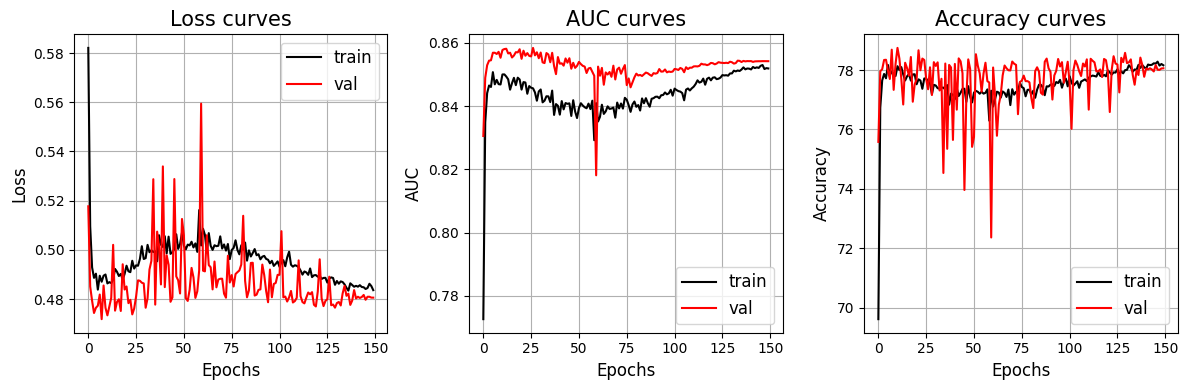

In [10]:
# Visualizing the loss and accuracy curves.
fig = plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history_train_loss,"k",label="train")
plt.plot(history_val_loss,"r",label="val")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss curves", fontsize=15)
plt.legend(fontsize=12)
plt.grid()


# AUC
plt.subplot(1, 3, 2)
plt.plot(history_train_auc,"k",label="train")
plt.plot(history_val_auc,"r",label="val")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.title("AUC curves", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(history_train_acc,"k",label="train")
plt.plot(history_val_acc,"r",label="val")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy curves", fontsize=15)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

In [11]:
def final_evaluation(model, data_loader):
    loss = 0
    correct, total = 0,0
    auc_metric = AUROC(task="binary")
    model.eval()
    auc_metric.reset()
    with torch.inference_mode():
        for data in data_loader:
            x, edge_index, batch_idx, y = data.x, data.edge_index, data.batch, data.y
            x, edge_index, batch_idx, y = x.to(device), edge_index.to(device), batch_idx.to(device), y.to(device)
            pred = model(x, edge_index, batch_idx)
            l = loss_fn(pred, y.unsqueeze(1).to(torch.float32))
            loss += l.detach().cpu().item()
            correct += torch.sum(y==(pred.squeeze() >= 0).float()).detach().cpu().item()
            total += len(y)
            auc_metric.update(torch.sigmoid(pred.squeeze()), y)
        loss /= len(data_loader)
        acc = correct / total * 100
        auc = auc_metric.compute().detach().cpu().item()
    return loss, acc, auc

In [12]:
# Final Metrics:
model.load_state_dict(torch.load('GNNmodel_1.pth'))
train_loss, train_accuracy, train_auc = final_evaluation(model,train_loader)
val_loss, val_accuracy, val_auc= final_evaluation(model,val_loader)
test_loss, test_accuracy, test_auc= final_evaluation(model,test_loader)
clear_output()
print("The final losses and accuracies on the training, validation and test sets are as follows:")
print(f"Train | loss: {train_loss:.5f} | Accuracy: {train_accuracy:.3f}% | AUC: {train_auc:.5f}")
print(f"Val   | loss: {val_loss:.5f}   | Accuracy: {val_accuracy:.3f}%   | AUC: {val_auc:.5f}")
print(f"Test  | loss: {test_loss:.5f}  | Accuracy: {test_accuracy:.3f}%  | AUC: {test_auc:.5f}")

The final losses and accuracies on the training, validation and test sets are as follows:
Train | loss: 0.47427 | Accuracy: 78.631% | AUC: 0.86022
Val   | loss: 0.47343   | Accuracy: 78.747%   | AUC: 0.85777
Test  | loss: 0.48079  | Accuracy: 77.707%  | AUC: 0.85222


In [13]:
# Training and Validation Loop:
torch.manual_seed(42)
model = GraphGNNModel(c_in = dataset.num_node_features,c_hidden = 16, c_out=1, num_layers=2, layer_name="GATv2").to(device)
loss_fn = BCEWithLogitsLoss()
optimizer = Adam(model.parameters(), lr=0.1, weight_decay=0.0)
scheduler = OneCycleLR(optimizer=optimizer, max_lr=0.1,steps_per_epoch=len(train_loader), epochs=150)

train_time_start_on_cpu = timer()
epochs = 150

best_val_acc = 50.
patience = 150
counter = 0

auc_metric_train = AUROC(task="binary")
auc_metric_val = AUROC(task="binary")
history_train_loss = []
history_val_loss = []
history_train_acc = []
history_val_acc = []
history_train_auc =[]
history_val_auc = []

for epoch in trange(epochs, desc="Training"):
    ### Training
    train_loss = 0
    correct, total = 0,0
    model.train()
    auc_metric_train.reset()
    for data in train_loader:
        x, edge_index, batch_idx, y = data.x, data.edge_index, data.batch, data.y
        x, edge_index, batch_idx, y = x.to(device), edge_index.to(device), batch_idx.to(device), y.to(device)
        y_pred = model(x, edge_index, batch_idx)
        loss = loss_fn(y_pred, y.unsqueeze(1).to(torch.float32))
        train_loss += loss.detach().cpu().item()
        correct += torch.sum(y==(y_pred.squeeze() >= 0).float()).detach().cpu().item()
        total += len(y)
        auc_metric_train.update(torch.sigmoid(y_pred.squeeze()), y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

    train_loss /= len(train_loader)
    train_acc = correct / total * 100
    train_auc = auc_metric_train.compute().detach().cpu().item()
    history_train_loss.append(train_loss) 
    history_train_acc.append(train_acc) 
    history_train_auc.append(train_auc) 

    ### Testing
    val_loss = 0
    correct, total = 0,0
    model.eval()
    auc_metric_val.reset()
    with torch.inference_mode():
        for data in val_loader:
            x, edge_index, batch_idx, y = data.x, data.edge_index, data.batch, data.y
            x, edge_index, batch_idx, y = x.to(device), edge_index.to(device), batch_idx.to(device), y.to(device)
            val_pred = model(x, edge_index, batch_idx)
            loss = loss_fn(val_pred, y.unsqueeze(1).to(torch.float32))
            val_loss += loss.detach().cpu().item()
            correct += torch.sum(y==(val_pred.squeeze() >= 0).float()).detach().cpu().item()
            total += len(y)
            auc_metric_val.update(torch.sigmoid(val_pred.squeeze()), y)

        val_loss /= len(val_loader)
        val_acc = correct / total * 100
        val_auc = auc_metric_val.compute().detach().cpu().item()
        history_val_loss.append(val_loss) 
        history_val_acc.append(val_acc) 
        history_val_auc.append(val_auc) 
        

        # Check for early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'GNNmodel_2.pth')
            print("\nSaving Best Model...........")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch + 1} as validation accuracy did not increase for {patience} epochs.')
                break


    print(f"\nEpoch: {epoch+1} | lr: {scheduler.optimizer.param_groups[0]['lr']} | train loss: {train_loss:.5f} | val loss: {val_loss:.5f} | train acc.: {train_acc:.5f}% | val acc.: {val_acc:.5f}% | train auc: {train_auc:.5f}| val auc: {val_auc:.5f}")
    print("                            ")

# Calculate training time
train_time_end_on_cpu = timer()
print(f"Time for training: {train_time_end_on_cpu - train_time_start_on_cpu}s")

Training:   1%|▏                                | 1/150 [00:20<49:55, 20.10s/it]


Saving Best Model...........

Epoch: 1 | lr: 0.004116944548162055 | train loss: 0.62731 | val loss: 0.52655 | train acc.: 63.61143% | val acc.: 74.42667% | train auc: 0.70228| val auc: 0.81909
                            


Training:   1%|▍                                | 2/150 [00:40<49:25, 20.04s/it]


Saving Best Model...........

Epoch: 2 | lr: 0.004467208358175462 | train loss: 0.53030 | val loss: 0.52334 | train acc.: 75.05571% | val acc.: 74.71333% | train auc: 0.81644| val auc: 0.82440
                            


Training:   2%|▋                                | 3/150 [00:59<48:29, 19.79s/it]


Saving Best Model...........

Epoch: 3 | lr: 0.005049084703248594 | train loss: 0.51793 | val loss: 0.49558 | train acc.: 76.03429% | val acc.: 77.10667% | train auc: 0.82832| val auc: 0.84321
                            


Training:   3%|▉                                | 4/150 [01:19<47:55, 19.70s/it]


Saving Best Model...........

Epoch: 4 | lr: 0.005859738280620599 | train loss: 0.50225 | val loss: 0.48542 | train acc.: 76.97286% | val acc.: 77.95333% | train auc: 0.83827| val auc: 0.85036
                            


Training:   3%|█                                | 5/150 [01:38<47:04, 19.48s/it]


Epoch: 5 | lr: 0.0068952190271113906 | train loss: 0.49856 | val loss: 0.49054 | train acc.: 77.38143% | val acc.: 77.92667% | train auc: 0.84250| val auc: 0.85255
                            


Training:   4%|█▎                               | 6/150 [01:57<46:42, 19.46s/it]


Epoch: 6 | lr: 0.008150481366553108 | train loss: 0.49590 | val loss: 0.49678 | train acc.: 77.56857% | val acc.: 77.43333% | train auc: 0.84450| val auc: 0.85254
                            


Training:   5%|█▌                               | 7/150 [02:17<46:21, 19.45s/it]


Epoch: 7 | lr: 0.009619408795316128 | train loss: 0.49500 | val loss: 0.50304 | train acc.: 77.61000% | val acc.: 77.02000% | train auc: 0.84537| val auc: 0.85417
                            


Training:   5%|█▊                               | 8/150 [02:36<46:10, 19.51s/it]


Saving Best Model...........

Epoch: 8 | lr: 0.01129484368613215 | train loss: 0.49531 | val loss: 0.48117 | train acc.: 77.41714% | val acc.: 78.45333% | train auc: 0.84429| val auc: 0.85468
                            


Training:   6%|█▉                               | 9/150 [02:56<45:44, 19.47s/it]


Saving Best Model...........

Epoch: 9 | lr: 0.01316862216498943 | train loss: 0.49295 | val loss: 0.47846 | train acc.: 77.79143% | val acc.: 78.61333% | train auc: 0.84666| val auc: 0.85604
                            


Training:   7%|██▏                             | 10/150 [03:15<45:32, 19.52s/it]


Epoch: 10 | lr: 0.01523161389115607 | train loss: 0.49599 | val loss: 0.48408 | train acc.: 77.61286% | val acc.: 78.03333% | train auc: 0.84440| val auc: 0.85428
                            


Training:   7%|██▎                             | 11/150 [03:35<45:14, 19.53s/it]


Epoch: 11 | lr: 0.01747376654649546 | train loss: 0.49424 | val loss: 0.50039 | train acc.: 77.63429% | val acc.: 77.49333% | train auc: 0.84563| val auc: 0.85646
                            


Training:   8%|██▌                             | 12/150 [03:55<45:17, 19.70s/it]


Epoch: 12 | lr: 0.019884154817291416 | train loss: 0.49399 | val loss: 0.51268 | train acc.: 77.81857% | val acc.: 75.38667% | train auc: 0.84723| val auc: 0.85443
                            


Training:   9%|██▊                             | 13/150 [04:15<45:02, 19.73s/it]


Saving Best Model...........

Epoch: 13 | lr: 0.022451033629909606 | train loss: 0.49738 | val loss: 0.49030 | train acc.: 77.45143% | val acc.: 78.66000% | train auc: 0.84340| val auc: 0.85517
                            


Training:   9%|██▉                             | 14/150 [04:35<44:48, 19.77s/it]


Epoch: 14 | lr: 0.02516189538089468 | train loss: 0.49551 | val loss: 0.48629 | train acc.: 77.65286% | val acc.: 78.31333% | train auc: 0.84525| val auc: 0.85678
                            


Training:  10%|███▏                            | 15/150 [04:54<44:20, 19.71s/it]


Epoch: 15 | lr: 0.028003530882638378 | train loss: 0.49341 | val loss: 0.47832 | train acc.: 77.53857% | val acc.: 78.59333% | train auc: 0.84713| val auc: 0.85632
                            


Training:  11%|███▍                            | 16/150 [05:14<44:10, 19.78s/it]


Saving Best Model...........

Epoch: 16 | lr: 0.03096209372764934 | train loss: 0.49979 | val loss: 0.47754 | train acc.: 77.39429% | val acc.: 78.85333% | train auc: 0.84295| val auc: 0.85838
                            


Training:  11%|███▋                            | 17/150 [05:34<43:54, 19.81s/it]


Epoch: 17 | lr: 0.03402316775779758 | train loss: 0.49763 | val loss: 0.48396 | train acc.: 77.51857% | val acc.: 78.46000% | train auc: 0.84489| val auc: 0.85510
                            


Training:  12%|███▊                            | 18/150 [05:54<43:34, 19.81s/it]


Epoch: 18 | lr: 0.037171837309777064 | train loss: 0.49808 | val loss: 0.48263 | train acc.: 77.36571% | val acc.: 77.94667% | train auc: 0.84278| val auc: 0.85498
                            


Training:  13%|████                            | 19/150 [06:14<43:22, 19.87s/it]


Epoch: 19 | lr: 0.0403927598945016 | train loss: 0.49462 | val loss: 0.48061 | train acc.: 77.56429% | val acc.: 78.35333% | train auc: 0.84508| val auc: 0.85843
                            


Training:  13%|████▎                           | 20/150 [06:34<43:13, 19.95s/it]


Epoch: 20 | lr: 0.043670240956290525 | train loss: 0.49288 | val loss: 0.58502 | train acc.: 77.90286% | val acc.: 70.64000% | train auc: 0.84824| val auc: 0.85751
                            


Training:  14%|████▍                           | 21/150 [06:54<42:51, 19.93s/it]


Epoch: 21 | lr: 0.04698831034756552 | train loss: 0.49647 | val loss: 0.47450 | train acc.: 77.52857% | val acc.: 78.76667% | train auc: 0.84487| val auc: 0.85921
                            


Training:  15%|████▋                           | 22/150 [07:14<42:36, 19.97s/it]


Epoch: 22 | lr: 0.05033080014642102 | train loss: 0.49999 | val loss: 0.53101 | train acc.: 77.45571% | val acc.: 74.54667% | train auc: 0.84233| val auc: 0.85675
                            


Training:  15%|████▉                           | 23/150 [07:34<42:08, 19.91s/it]


Epoch: 23 | lr: 0.05368142343788773 | train loss: 0.49709 | val loss: 0.48666 | train acc.: 77.70429% | val acc.: 77.17333% | train auc: 0.84528| val auc: 0.85667
                            


Training:  16%|█████                           | 24/150 [07:54<41:56, 19.97s/it]


Epoch: 24 | lr: 0.05702385367501223 | train loss: 0.49511 | val loss: 0.47874 | train acc.: 77.73714% | val acc.: 77.96000% | train auc: 0.84657| val auc: 0.85952
                            


Training:  17%|█████▎                          | 25/150 [08:14<41:31, 19.93s/it]


Epoch: 25 | lr: 0.06034180423305104 | train loss: 0.49883 | val loss: 0.47400 | train acc.: 77.59143% | val acc.: 78.76000% | train auc: 0.84422| val auc: 0.85786
                            


Training:  17%|█████▌                          | 26/150 [08:34<41:23, 20.03s/it]


Epoch: 26 | lr: 0.06361910776913611 | train loss: 0.50423 | val loss: 0.54817 | train acc.: 77.31714% | val acc.: 74.72000% | train auc: 0.84094| val auc: 0.85562
                            


Training:  18%|█████▊                          | 27/150 [08:54<41:04, 20.04s/it]


Epoch: 27 | lr: 0.06683979500071667 | train loss: 0.50273 | val loss: 0.49863 | train acc.: 77.26000% | val acc.: 77.44000% | train auc: 0.84109| val auc: 0.85744
                            


Training:  19%|█████▉                          | 28/150 [09:14<41:03, 20.19s/it]


Epoch: 28 | lr: 0.0699881725189149 | train loss: 0.49974 | val loss: 0.48236 | train acc.: 77.61857% | val acc.: 78.17333% | train auc: 0.84459| val auc: 0.85763
                            


Training:  19%|██████▏                         | 29/150 [09:34<40:37, 20.15s/it]


Epoch: 29 | lr: 0.0730488992576346 | train loss: 0.50006 | val loss: 0.53609 | train acc.: 77.62286% | val acc.: 73.93333% | train auc: 0.84402| val auc: 0.85777
                            


Training:  20%|██████▍                         | 30/150 [09:54<40:11, 20.09s/it]


Epoch: 30 | lr: 0.07600706124581291 | train loss: 0.50744 | val loss: 0.47398 | train acc.: 77.32429% | val acc.: 78.64000% | train auc: 0.83996| val auc: 0.85892
                            


Training:  21%|██████▌                         | 31/150 [10:15<39:55, 20.13s/it]


Epoch: 31 | lr: 0.07884824427857082 | train loss: 0.50725 | val loss: 0.47597 | train acc.: 77.05286% | val acc.: 78.32000% | train auc: 0.83917| val auc: 0.85807
                            


Training:  21%|██████▊                         | 32/150 [10:35<39:52, 20.28s/it]


Epoch: 32 | lr: 0.08155860415315785 | train loss: 0.50140 | val loss: 0.47518 | train acc.: 77.33143% | val acc.: 78.46000% | train auc: 0.84166| val auc: 0.85995
                            


Training:  22%|███████                         | 33/150 [10:55<39:21, 20.19s/it]


Epoch: 33 | lr: 0.08412493412745356 | train loss: 0.50604 | val loss: 0.47375 | train acc.: 77.27143% | val acc.: 78.54667% | train auc: 0.84051| val auc: 0.85907
                            


Training:  23%|███████▎                        | 34/150 [11:16<39:21, 20.36s/it]


Epoch: 34 | lr: 0.08653472927232132 | train loss: 0.51353 | val loss: 0.47759 | train acc.: 76.60000% | val acc.: 78.68000% | train auc: 0.83413| val auc: 0.85741
                            


Training:  23%|███████▍                        | 35/150 [11:36<39:00, 20.35s/it]


Epoch: 35 | lr: 0.08877624740424538 | train loss: 0.50151 | val loss: 0.47763 | train acc.: 77.50286% | val acc.: 78.49333% | train auc: 0.84256| val auc: 0.85732
                            


Training:  24%|███████▋                        | 36/150 [11:56<38:28, 20.25s/it]


Epoch: 36 | lr: 0.09083856630134503 | train loss: 0.50653 | val loss: 0.47645 | train acc.: 77.04429% | val acc.: 78.69333% | train auc: 0.83867| val auc: 0.85783
                            


Training:  25%|███████▉                        | 37/150 [12:16<37:51, 20.10s/it]


Epoch: 37 | lr: 0.09271163692397084 | train loss: 0.50286 | val loss: 0.51800 | train acc.: 77.32571% | val acc.: 77.61333% | train auc: 0.84157| val auc: 0.85412
                            


Training:  25%|████████                        | 38/150 [12:37<37:41, 20.19s/it]


Epoch: 38 | lr: 0.09438633238055456 | train loss: 0.51102 | val loss: 0.51055 | train acc.: 76.87714% | val acc.: 76.28667% | train auc: 0.83583| val auc: 0.85755
                            


Training:  26%|████████▎                       | 39/150 [12:56<37:04, 20.04s/it]


Epoch: 39 | lr: 0.09585449240011785 | train loss: 0.50840 | val loss: 0.49386 | train acc.: 77.17571% | val acc.: 78.51333% | train auc: 0.83866| val auc: 0.85661
                            


Training:  27%|████████▌                       | 40/150 [13:17<37:06, 20.24s/it]


Epoch: 40 | lr: 0.09710896309473918 | train loss: 0.51349 | val loss: 0.48228 | train acc.: 76.72714% | val acc.: 78.02667% | train auc: 0.83455| val auc: 0.85130
                            


Training:  27%|████████▋                       | 41/150 [13:37<36:52, 20.30s/it]


Epoch: 41 | lr: 0.09814363181822833 | train loss: 0.51875 | val loss: 0.48857 | train acc.: 76.53286% | val acc.: 78.22000% | train auc: 0.83198| val auc: 0.85435
                            


Training:  28%|████████▉                       | 42/150 [13:58<36:28, 20.26s/it]


Epoch: 42 | lr: 0.09895345695115339 | train loss: 0.51282 | val loss: 0.47951 | train acc.: 76.64143% | val acc.: 78.16667% | train auc: 0.83497| val auc: 0.85719
                            


Training:  29%|█████████▏                      | 43/150 [14:18<36:11, 20.30s/it]


Epoch: 43 | lr: 0.09953449246708684 | train loss: 0.51030 | val loss: 0.47731 | train acc.: 76.88714% | val acc.: 78.29333% | train auc: 0.83790| val auc: 0.85719
                            


Training:  29%|█████████▍                      | 44/150 [14:38<35:59, 20.38s/it]


Epoch: 44 | lr: 0.09988390716036717 | train loss: 0.51213 | val loss: 0.48026 | train acc.: 76.93714% | val acc.: 78.02000% | train auc: 0.83570| val auc: 0.85654
                            


Training:  30%|█████████▌                      | 45/150 [14:59<35:36, 20.35s/it]


Epoch: 45 | lr: 0.09999999970190254 | train loss: 0.50908 | val loss: 0.47740 | train acc.: 76.99143% | val acc.: 78.31333% | train auc: 0.83766| val auc: 0.85497
                            


Training:  31%|█████████▊                      | 46/150 [15:19<35:19, 20.38s/it]


Epoch: 46 | lr: 0.0999774580726822 | train loss: 0.50791 | val loss: 0.47922 | train acc.: 76.90714% | val acc.: 78.14667% | train auc: 0.83761| val auc: 0.85877
                            


Training:  31%|██████████                      | 47/150 [15:40<35:08, 20.47s/it]


Epoch: 47 | lr: 0.09991018002891718 | train loss: 0.51280 | val loss: 0.48794 | train acc.: 76.75714% | val acc.: 77.80667% | train auc: 0.83482| val auc: 0.85308
                            


Training:  32%|██████████▏                     | 48/150 [16:00<34:47, 20.46s/it]


Epoch: 48 | lr: 0.09979822579356826 | train loss: 0.50903 | val loss: 0.47790 | train acc.: 76.90286% | val acc.: 78.17333% | train auc: 0.83771| val auc: 0.85671
                            


Training:  33%|██████████▍                     | 49/150 [16:21<34:26, 20.46s/it]


Epoch: 49 | lr: 0.09964169558083842 | train loss: 0.52132 | val loss: 0.48713 | train acc.: 75.90143% | val acc.: 77.60000% | train auc: 0.82722| val auc: 0.85265
                            


Training:  33%|██████████▋                     | 50/150 [16:41<34:02, 20.43s/it]


Epoch: 50 | lr: 0.0994407295064674 | train loss: 0.50946 | val loss: 0.48609 | train acc.: 76.89571% | val acc.: 77.84000% | train auc: 0.83574| val auc: 0.85115
                            


Training:  34%|██████████▉                     | 51/150 [17:02<33:47, 20.48s/it]


Epoch: 51 | lr: 0.09919550746230918 | train loss: 0.50893 | val loss: 0.54350 | train acc.: 77.07143% | val acc.: 72.58000% | train auc: 0.83631| val auc: 0.85702
                            


Training:  35%|███████████                     | 52/150 [17:22<33:23, 20.44s/it]


Epoch: 52 | lr: 0.09890624895530445 | train loss: 0.51323 | val loss: 0.54851 | train acc.: 76.87000% | val acc.: 74.03333% | train auc: 0.83483| val auc: 0.85680
                            


Training:  35%|███████████▎                    | 53/150 [17:42<32:59, 20.41s/it]


Epoch: 53 | lr: 0.09857321291099211 | train loss: 0.52105 | val loss: 0.47649 | train acc.: 76.26857% | val acc.: 78.48667% | train auc: 0.82772| val auc: 0.85612
                            


Training:  36%|███████████▌                    | 54/150 [18:03<32:35, 20.37s/it]


Epoch: 54 | lr: 0.09819669744173594 | train loss: 0.50967 | val loss: 0.48202 | train acc.: 76.98571% | val acc.: 77.77333% | train auc: 0.83641| val auc: 0.85451
                            


Training:  37%|███████████▋                    | 55/150 [18:23<32:22, 20.45s/it]


Epoch: 55 | lr: 0.09777703957987346 | train loss: 0.52296 | val loss: 0.57203 | train acc.: 75.89571% | val acc.: 69.61333% | train auc: 0.82622| val auc: 0.84452
                            


Training:  37%|███████████▉                    | 56/150 [18:44<32:04, 20.48s/it]


Epoch: 56 | lr: 0.09731461497602663 | train loss: 0.52412 | val loss: 0.49850 | train acc.: 76.11714% | val acc.: 76.86000% | train auc: 0.82655| val auc: 0.85345
                            


Training:  38%|████████████▏                   | 57/150 [19:05<31:49, 20.53s/it]


Epoch: 57 | lr: 0.09680983756284339 | train loss: 0.51894 | val loss: 0.48853 | train acc.: 76.34000% | val acc.: 78.30000% | train auc: 0.83142| val auc: 0.85149
                            


Training:  39%|████████████▎                   | 58/150 [19:25<31:36, 20.61s/it]


Epoch: 58 | lr: 0.09626315918447208 | train loss: 0.51523 | val loss: 0.49563 | train acc.: 76.49286% | val acc.: 77.62000% | train auc: 0.83476| val auc: 0.85097
                            


Training:  39%|████████████▌                   | 59/150 [19:46<31:26, 20.73s/it]


Epoch: 59 | lr: 0.09567506919209964 | train loss: 0.51313 | val loss: 0.48904 | train acc.: 76.59714% | val acc.: 77.21333% | train auc: 0.83425| val auc: 0.85356
                            


Training:  40%|████████████▊                   | 60/150 [20:07<31:13, 20.81s/it]


Epoch: 60 | lr: 0.095046094005916 | train loss: 0.51798 | val loss: 0.48576 | train acc.: 76.49714% | val acc.: 78.14000% | train auc: 0.83145| val auc: 0.85191
                            


Training:  41%|█████████████                   | 61/150 [20:28<30:58, 20.88s/it]


Epoch: 61 | lr: 0.09437679664389681 | train loss: 0.52215 | val loss: 0.50588 | train acc.: 76.57143% | val acc.: 77.35333% | train auc: 0.83054| val auc: 0.84654
                            


Training:  41%|█████████████▏                  | 62/150 [20:49<30:37, 20.88s/it]


Epoch: 62 | lr: 0.09366777621782604 | train loss: 0.52116 | val loss: 0.47962 | train acc.: 76.38429% | val acc.: 78.52000% | train auc: 0.83023| val auc: 0.85621
                            


Training:  42%|█████████████▍                  | 63/150 [21:10<30:21, 20.94s/it]


Epoch: 63 | lr: 0.09291966739700974 | train loss: 0.51260 | val loss: 0.51080 | train acc.: 76.99143% | val acc.: 77.62000% | train auc: 0.83689| val auc: 0.85456
                            


Training:  43%|█████████████▋                  | 64/150 [21:32<30:07, 21.02s/it]


Epoch: 64 | lr: 0.0921331398401612 | train loss: 0.52560 | val loss: 0.48047 | train acc.: 76.19714% | val acc.: 78.36000% | train auc: 0.82828| val auc: 0.85375
                            


Training:  43%|█████████████▊                  | 65/150 [21:52<29:25, 20.77s/it]


Epoch: 65 | lr: 0.09130889759596551 | train loss: 0.51704 | val loss: 0.48204 | train acc.: 76.54857% | val acc.: 78.07333% | train auc: 0.83234| val auc: 0.85371
                            


Training:  44%|██████████████                  | 66/150 [22:12<28:49, 20.59s/it]


Epoch: 66 | lr: 0.0904476784728609 | train loss: 0.51121 | val loss: 0.55361 | train acc.: 76.82286% | val acc.: 77.52667% | train auc: 0.83574| val auc: 0.85656
                            


Training:  45%|██████████████▎                 | 67/150 [22:32<28:16, 20.44s/it]


Epoch: 67 | lr: 0.08955025337860001 | train loss: 0.52778 | val loss: 0.49959 | train acc.: 76.06429% | val acc.: 77.62000% | train auc: 0.82560| val auc: 0.85252
                            


Training:  45%|██████████████▌                 | 68/150 [22:52<27:36, 20.20s/it]


Epoch: 68 | lr: 0.08861742563018313 | train loss: 0.51475 | val loss: 0.49637 | train acc.: 76.79286% | val acc.: 77.56667% | train auc: 0.83490| val auc: 0.85457
                            


Training:  46%|██████████████▋                 | 69/150 [23:11<27:05, 20.07s/it]


Epoch: 69 | lr: 0.08765003023478078 | train loss: 0.52091 | val loss: 0.49403 | train acc.: 76.44286% | val acc.: 77.94667% | train auc: 0.83160| val auc: 0.85335
                            


Training:  47%|██████████████▉                 | 70/150 [23:31<26:41, 20.02s/it]


Epoch: 70 | lr: 0.08664893314228911 | train loss: 0.51328 | val loss: 0.48429 | train acc.: 76.85714% | val acc.: 78.52667% | train auc: 0.83550| val auc: 0.85360
                            


Training:  47%|███████████████▏                | 71/150 [23:51<26:22, 20.04s/it]


Epoch: 71 | lr: 0.08561503047018747 | train loss: 0.51485 | val loss: 0.49645 | train acc.: 76.66000% | val acc.: 77.46667% | train auc: 0.83407| val auc: 0.85511
                            


Training:  48%|███████████████▎                | 72/150 [24:12<26:07, 20.09s/it]


Epoch: 72 | lr: 0.08454924770139191 | train loss: 0.51404 | val loss: 0.50520 | train acc.: 76.64857% | val acc.: 77.58000% | train auc: 0.83313| val auc: 0.85247
                            


Training:  49%|███████████████▌                | 73/150 [24:32<25:55, 20.20s/it]


Epoch: 73 | lr: 0.08345253885582266 | train loss: 0.51423 | val loss: 0.48228 | train acc.: 76.88571% | val acc.: 78.36000% | train auc: 0.83597| val auc: 0.85435
                            


Training:  49%|███████████████▊                | 74/150 [24:52<25:36, 20.21s/it]


Epoch: 74 | lr: 0.08232588563642707 | train loss: 0.51119 | val loss: 0.49926 | train acc.: 77.13571% | val acc.: 77.80667% | train auc: 0.83843| val auc: 0.85533
                            


Training:  50%|████████████████                | 75/150 [25:12<25:12, 20.17s/it]


Epoch: 75 | lr: 0.08117029655042249 | train loss: 0.52185 | val loss: 0.50289 | train acc.: 76.33286% | val acc.: 77.13333% | train auc: 0.83031| val auc: 0.85635
                            


Training:  51%|████████████████▏               | 76/150 [25:32<24:46, 20.09s/it]


Epoch: 76 | lr: 0.07998680600654583 | train loss: 0.50997 | val loss: 0.49345 | train acc.: 76.89714% | val acc.: 78.62000% | train auc: 0.83802| val auc: 0.85807
                            


Training:  51%|████████████████▍               | 77/150 [25:53<24:29, 20.14s/it]


Epoch: 77 | lr: 0.07877647338911749 | train loss: 0.50937 | val loss: 0.49347 | train acc.: 77.24571% | val acc.: 77.96000% | train auc: 0.83917| val auc: 0.85764
                            


Training:  52%|████████████████▋               | 78/150 [26:12<24:05, 20.08s/it]


Epoch: 78 | lr: 0.07754038210974903 | train loss: 0.51504 | val loss: 0.49431 | train acc.: 76.85429% | val acc.: 77.88667% | train auc: 0.83580| val auc: 0.85754
                            


Training:  53%|████████████████▊               | 79/150 [26:33<23:47, 20.10s/it]


Epoch: 79 | lr: 0.07627963863754308 | train loss: 0.50720 | val loss: 0.49147 | train acc.: 77.21000% | val acc.: 77.89333% | train auc: 0.84111| val auc: 0.85708
                            


Training:  53%|█████████████████               | 80/150 [26:53<23:25, 20.07s/it]


Epoch: 80 | lr: 0.07499537150865349 | train loss: 0.51100 | val loss: 0.49083 | train acc.: 77.16571% | val acc.: 78.30000% | train auc: 0.83879| val auc: 0.85737
                            


Training:  54%|█████████████████▎              | 81/150 [27:13<23:04, 20.06s/it]


Epoch: 81 | lr: 0.07368873031609274 | train loss: 0.51165 | val loss: 0.47810 | train acc.: 76.87000% | val acc.: 78.74667% | train auc: 0.83890| val auc: 0.85852
                            


Training:  55%|█████████████████▍              | 82/150 [27:32<22:38, 19.98s/it]


Epoch: 82 | lr: 0.07236088468069053 | train loss: 0.51094 | val loss: 0.49268 | train acc.: 76.93714% | val acc.: 78.22000% | train auc: 0.83730| val auc: 0.85932
                            


Training:  55%|█████████████████▋              | 83/150 [27:53<22:23, 20.06s/it]


Epoch: 83 | lr: 0.07101302320412464 | train loss: 0.50578 | val loss: 0.50272 | train acc.: 77.43571% | val acc.: 77.45333% | train auc: 0.84199| val auc: 0.85936
                            


Training:  56%|█████████████████▉              | 84/150 [28:13<22:03, 20.05s/it]


Epoch: 84 | lr: 0.06964635240496153 | train loss: 0.50583 | val loss: 0.47985 | train acc.: 77.31429% | val acc.: 78.51333% | train auc: 0.84196| val auc: 0.85754
                            


Training:  57%|██████████████████▏             | 85/150 [28:33<21:46, 20.09s/it]


Epoch: 85 | lr: 0.06826209563865873 | train loss: 0.50671 | val loss: 0.48320 | train acc.: 77.28714% | val acc.: 78.76667% | train auc: 0.84142| val auc: 0.85830
                            


Training:  57%|██████████████████▎             | 86/150 [28:53<21:26, 20.10s/it]


Epoch: 86 | lr: 0.06686149200249615 | train loss: 0.50711 | val loss: 0.48580 | train acc.: 77.32714% | val acc.: 78.57333% | train auc: 0.84149| val auc: 0.85895
                            


Training:  58%|██████████████████▌             | 87/150 [29:13<21:01, 20.02s/it]


Epoch: 87 | lr: 0.0654457952264161 | train loss: 0.51473 | val loss: 0.48252 | train acc.: 77.15857% | val acc.: 78.70000% | train auc: 0.83854| val auc: 0.85985
                            


Training:  59%|██████████████████▊             | 88/150 [29:33<20:41, 20.02s/it]


Epoch: 88 | lr: 0.06401627255076521 | train loss: 0.50843 | val loss: 0.48670 | train acc.: 77.26286% | val acc.: 77.88000% | train auc: 0.84080| val auc: 0.85789
                            


Training:  59%|██████████████████▉             | 89/150 [29:53<20:20, 20.00s/it]


Epoch: 89 | lr: 0.06257420359194273 | train loss: 0.51977 | val loss: 0.47980 | train acc.: 76.96571% | val acc.: 78.46000% | train auc: 0.83776| val auc: 0.85834
                            


Training:  60%|███████████████████▏            | 90/150 [30:13<20:05, 20.09s/it]


Epoch: 90 | lr: 0.0611208791969705 | train loss: 0.51040 | val loss: 0.48927 | train acc.: 77.29000% | val acc.: 78.20000% | train auc: 0.84024| val auc: 0.85757
                            


Training:  61%|███████████████████▍            | 91/150 [30:34<19:54, 20.25s/it]


Epoch: 91 | lr: 0.059657600288010114 | train loss: 0.50704 | val loss: 0.55300 | train acc.: 77.55429% | val acc.: 74.00000% | train auc: 0.84334| val auc: 0.85634
                            


Training:  61%|███████████████████▋            | 92/150 [30:54<19:39, 20.34s/it]


Epoch: 92 | lr: 0.05818567669786135 | train loss: 0.50978 | val loss: 0.50541 | train acc.: 77.30571% | val acc.: 77.49333% | train auc: 0.84171| val auc: 0.86092
                            


Training:  62%|███████████████████▊            | 93/150 [31:15<19:19, 20.34s/it]


Epoch: 93 | lr: 0.056706425997484364 | train loss: 0.50504 | val loss: 0.48170 | train acc.: 77.37714% | val acc.: 78.72000% | train auc: 0.84300| val auc: 0.85742
                            


Training:  63%|████████████████████            | 94/150 [31:34<18:51, 20.20s/it]


Epoch: 94 | lr: 0.05522117231659539 | train loss: 0.50187 | val loss: 0.49851 | train acc.: 77.48571% | val acc.: 77.84000% | train auc: 0.84518| val auc: 0.86112
                            


Training:  63%|████████████████████▎           | 95/150 [31:55<18:35, 20.29s/it]


Epoch: 95 | lr: 0.05373124515839114 | train loss: 0.50320 | val loss: 0.49169 | train acc.: 77.51000% | val acc.: 77.68667% | train auc: 0.84550| val auc: 0.85256
                            


Training:  64%|████████████████████▍           | 96/150 [32:15<18:16, 20.31s/it]


Epoch: 96 | lr: 0.05223797820946352 | train loss: 0.51373 | val loss: 0.47986 | train acc.: 76.95857% | val acc.: 78.78667% | train auc: 0.83864| val auc: 0.86019
                            


Training:  65%|████████████████████▋           | 97/150 [32:36<17:53, 20.26s/it]


Epoch: 97 | lr: 0.05074270814596943 | train loss: 0.50113 | val loss: 0.48697 | train acc.: 77.70143% | val acc.: 78.77333% | train auc: 0.84587| val auc: 0.86054
                            


Training:  65%|████████████████████▉           | 98/150 [32:55<17:27, 20.14s/it]


Epoch: 98 | lr: 0.0492467734371246 | train loss: 0.50698 | val loss: 0.49116 | train acc.: 77.31286% | val acc.: 78.44000% | train auc: 0.84399| val auc: 0.86146
                            


Training:  66%|█████████████████████           | 99/150 [33:16<17:14, 20.28s/it]


Epoch: 99 | lr: 0.04775151314709234 | train loss: 0.50669 | val loss: 0.49177 | train acc.: 77.53857% | val acc.: 78.26667% | train auc: 0.84293| val auc: 0.86084
                            


Training:  67%|████████████████████▋          | 100/150 [33:36<16:56, 20.34s/it]


Epoch: 100 | lr: 0.04625826573633984 | train loss: 0.50487 | val loss: 0.48467 | train acc.: 77.58857% | val acc.: 78.58667% | train auc: 0.84416| val auc: 0.85724
                            


Training:  67%|████████████████████▊          | 101/150 [33:57<16:41, 20.45s/it]


Epoch: 101 | lr: 0.04476836786353469 | train loss: 0.50763 | val loss: 0.47890 | train acc.: 77.45429% | val acc.: 78.07333% | train auc: 0.84320| val auc: 0.85998
                            


Training:  68%|█████████████████████          | 102/150 [34:18<16:20, 20.43s/it]


Epoch: 102 | lr: 0.04328315318905433 | train loss: 0.50313 | val loss: 0.49436 | train acc.: 77.50143% | val acc.: 77.74000% | train auc: 0.84563| val auc: 0.85998
                            


Training:  69%|█████████████████████▎         | 103/150 [34:38<16:04, 20.52s/it]


Saving Best Model...........

Epoch: 103 | lr: 0.04180395118117954 | train loss: 0.50038 | val loss: 0.47590 | train acc.: 77.69571% | val acc.: 79.06667% | train auc: 0.84732| val auc: 0.86043
                            


Training:  69%|█████████████████████▍         | 104/150 [34:58<15:35, 20.34s/it]


Epoch: 104 | lr: 0.040332085926040116 | train loss: 0.50790 | val loss: 0.50505 | train acc.: 77.59714% | val acc.: 77.26000% | train auc: 0.84377| val auc: 0.85962
                            


Training:  70%|█████████████████████▋         | 105/150 [35:19<15:22, 20.49s/it]


Epoch: 105 | lr: 0.038868874942378485 | train loss: 0.50079 | val loss: 0.48062 | train acc.: 77.61000% | val acc.: 78.20667% | train auc: 0.84547| val auc: 0.86002
                            


Training:  71%|█████████████████████▉         | 106/150 [35:40<15:04, 20.56s/it]


Epoch: 106 | lr: 0.03741562800219212 | train loss: 0.50124 | val loss: 0.47856 | train acc.: 77.75714% | val acc.: 78.88000% | train auc: 0.84692| val auc: 0.86016
                            


Training:  71%|██████████████████████         | 107/150 [36:01<14:46, 20.62s/it]


Epoch: 107 | lr: 0.03597364595831005 | train loss: 0.50380 | val loss: 0.47769 | train acc.: 77.70143% | val acc.: 78.43333% | train auc: 0.84590| val auc: 0.86121
                            


Training:  72%|██████████████████████▎        | 108/150 [36:21<14:26, 20.62s/it]


Epoch: 108 | lr: 0.03454421957995347 | train loss: 0.49913 | val loss: 0.48346 | train acc.: 77.86143% | val acc.: 78.58667% | train auc: 0.84811| val auc: 0.86031
                            


Training:  73%|██████████████████████▌        | 109/150 [36:42<14:08, 20.69s/it]


Epoch: 109 | lr: 0.03312862839732254 | train loss: 0.49787 | val loss: 0.47770 | train acc.: 77.83143% | val acc.: 78.94667% | train auc: 0.85018| val auc: 0.86085
                            


Training:  73%|██████████████████████▋        | 110/150 [37:03<13:49, 20.73s/it]


Saving Best Model...........

Epoch: 110 | lr: 0.031728139556243456 | train loss: 0.49994 | val loss: 0.47426 | train acc.: 77.87286% | val acc.: 79.09333% | train auc: 0.84926| val auc: 0.86195
                            


Training:  74%|██████████████████████▉        | 111/150 [37:24<13:31, 20.80s/it]


Epoch: 111 | lr: 0.03034400668390136 | train loss: 0.49892 | val loss: 0.47619 | train acc.: 77.93429% | val acc.: 78.82000% | train auc: 0.84943| val auc: 0.86012
                            


Training:  75%|███████████████████████▏       | 112/150 [37:44<13:09, 20.77s/it]


Epoch: 112 | lr: 0.02897746876667426 | train loss: 0.49873 | val loss: 0.48453 | train acc.: 77.79857% | val acc.: 78.62000% | train auc: 0.84898| val auc: 0.86133
                            


Training:  75%|███████████████████████▎       | 113/150 [38:05<12:47, 20.73s/it]


Epoch: 113 | lr: 0.02762974904107243 | train loss: 0.49998 | val loss: 0.47430 | train acc.: 77.91429% | val acc.: 78.98000% | train auc: 0.84959| val auc: 0.86096
                            


Training:  76%|███████████████████████▌       | 114/150 [38:26<12:27, 20.76s/it]


Epoch: 114 | lr: 0.026302053898775962 | train loss: 0.49447 | val loss: 0.49108 | train acc.: 77.91000% | val acc.: 78.12000% | train auc: 0.85055| val auc: 0.86027
                            


Training:  77%|███████████████████████▊       | 115/150 [38:46<12:03, 20.68s/it]


Epoch: 115 | lr: 0.02499557180675094 | train loss: 0.49293 | val loss: 0.47700 | train acc.: 78.18143% | val acc.: 78.91333% | train auc: 0.85136| val auc: 0.86097
                            


Training:  77%|███████████████████████▉       | 116/150 [39:07<11:44, 20.71s/it]


Epoch: 116 | lr: 0.02371147224341054 | train loss: 0.49865 | val loss: 0.47728 | train acc.: 77.95000% | val acc.: 78.92000% | train auc: 0.84896| val auc: 0.86027
                            


Training:  78%|████████████████████████▏      | 117/150 [39:28<11:22, 20.69s/it]


Epoch: 117 | lr: 0.022450904651773372 | train loss: 0.49654 | val loss: 0.48119 | train acc.: 78.01571% | val acc.: 78.77333% | train auc: 0.85094| val auc: 0.86092
                            


Training:  79%|████████████████████████▍      | 118/150 [39:49<11:01, 20.68s/it]


Epoch: 118 | lr: 0.021214997410556376 | train loss: 0.49607 | val loss: 0.47646 | train acc.: 78.01143% | val acc.: 79.04667% | train auc: 0.85115| val auc: 0.86130
                            


Training:  79%|████████████████████████▌      | 119/150 [40:10<10:47, 20.88s/it]


Epoch: 119 | lr: 0.020004856824123105 | train loss: 0.49557 | val loss: 0.47457 | train acc.: 78.09571% | val acc.: 78.90667% | train auc: 0.85072| val auc: 0.86076
                            


Training:  80%|████████████████████████▊      | 120/150 [40:31<10:30, 21.01s/it]


Saving Best Model...........

Epoch: 120 | lr: 0.01882156613219135 | train loss: 0.49548 | val loss: 0.47455 | train acc.: 78.23286% | val acc.: 79.15333% | train auc: 0.85286| val auc: 0.86138
                            


Training:  81%|█████████████████████████      | 121/150 [40:52<10:08, 20.99s/it]


Epoch: 121 | lr: 0.017666184540186997 | train loss: 0.49455 | val loss: 0.48134 | train acc.: 78.02571% | val acc.: 78.74000% | train auc: 0.85093| val auc: 0.86034
                            


Training:  81%|█████████████████████████▏     | 122/150 [41:13<09:49, 21.05s/it]


Epoch: 122 | lr: 0.016539746271111655 | train loss: 0.49359 | val loss: 0.47317 | train acc.: 78.23000% | val acc.: 79.11333% | train auc: 0.85311| val auc: 0.86151
                            


Training:  82%|█████████████████████████▍     | 123/150 [41:34<09:26, 21.00s/it]


Epoch: 123 | lr: 0.015443259639773093 | train loss: 0.49199 | val loss: 0.47338 | train acc.: 78.24286% | val acc.: 78.97333% | train auc: 0.85295| val auc: 0.86098
                            


Training:  83%|█████████████████████████▋     | 124/150 [41:55<09:04, 20.96s/it]


Epoch: 124 | lr: 0.014377706150206802 | train loss: 0.48943 | val loss: 0.48044 | train acc.: 78.23571% | val acc.: 78.64667% | train auc: 0.85420| val auc: 0.86157
                            


Training:  83%|█████████████████████████▊     | 125/150 [42:16<08:44, 21.00s/it]


Epoch: 125 | lr: 0.013344039617097032 | train loss: 0.49303 | val loss: 0.47371 | train acc.: 78.08714% | val acc.: 79.04000% | train auc: 0.85365| val auc: 0.86143
                            


Training:  84%|██████████████████████████     | 126/150 [42:37<08:24, 21.04s/it]


Epoch: 126 | lr: 0.012343185311983501 | train loss: 0.49322 | val loss: 0.47878 | train acc.: 78.10286% | val acc.: 78.81333% | train auc: 0.85301| val auc: 0.86149
                            


Training:  85%|██████████████████████████▏    | 127/150 [42:59<08:05, 21.10s/it]


Epoch: 127 | lr: 0.011376039135017961 | train loss: 0.49394 | val loss: 0.49305 | train acc.: 78.18286% | val acc.: 78.03333% | train auc: 0.85229| val auc: 0.86176
                            


Training:  85%|██████████████████████████▍    | 128/150 [43:19<07:38, 20.82s/it]


Epoch: 128 | lr: 0.010443466813012284 | train loss: 0.49111 | val loss: 0.47678 | train acc.: 78.33857% | val acc.: 79.02000% | train auc: 0.85485| val auc: 0.86246
                            


Training:  86%|██████████████████████████▋    | 129/150 [43:39<07:11, 20.52s/it]


Epoch: 129 | lr: 0.009546303124495753 | train loss: 0.49117 | val loss: 0.47720 | train acc.: 78.26143% | val acc.: 78.90000% | train auc: 0.85469| val auc: 0.86194
                            


Training:  87%|██████████████████████████▊    | 130/150 [43:58<06:45, 20.28s/it]


Epoch: 130 | lr: 0.008685351152475136 | train loss: 0.49076 | val loss: 0.47381 | train acc.: 78.24857% | val acc.: 78.85333% | train auc: 0.85449| val auc: 0.86216
                            


Training:  87%|███████████████████████████    | 131/150 [44:19<06:25, 20.30s/it]


Epoch: 131 | lr: 0.007861381565566695 | train loss: 0.49080 | val loss: 0.47451 | train acc.: 78.25857% | val acc.: 79.07333% | train auc: 0.85567| val auc: 0.86238
                            


Training:  88%|███████████████████████████▎   | 132/150 [44:39<06:04, 20.26s/it]


Epoch: 132 | lr: 0.007075131928143399 | train loss: 0.49075 | val loss: 0.47717 | train acc.: 78.28143% | val acc.: 78.98667% | train auc: 0.85488| val auc: 0.86211
                            


Training:  89%|███████████████████████████▍   | 133/150 [44:59<05:43, 20.22s/it]


Epoch: 133 | lr: 0.006327306040114862 | train loss: 0.48882 | val loss: 0.47995 | train acc.: 78.32714% | val acc.: 78.84667% | train auc: 0.85543| val auc: 0.86260
                            


Training:  89%|███████████████████████████▋   | 134/150 [45:19<05:24, 20.25s/it]


Epoch: 134 | lr: 0.005618573306931184 | train loss: 0.49082 | val loss: 0.47745 | train acc.: 78.29000% | val acc.: 78.85333% | train auc: 0.85555| val auc: 0.86217
                            


Training:  90%|███████████████████████████▉   | 135/150 [45:39<05:01, 20.11s/it]


Epoch: 135 | lr: 0.004949568140374333 | train loss: 0.48839 | val loss: 0.47470 | train acc.: 78.29857% | val acc.: 79.12667% | train auc: 0.85623| val auc: 0.86208
                            


Training:  91%|████████████████████████████   | 136/150 [45:59<04:41, 20.12s/it]


Epoch: 136 | lr: 0.004320889390673785 | train loss: 0.48674 | val loss: 0.47306 | train acc.: 78.27143% | val acc.: 79.08667% | train auc: 0.85599| val auc: 0.86228
                            


Training:  91%|████████████████████████████▎  | 137/150 [46:19<04:21, 20.12s/it]


Epoch: 137 | lr: 0.003733099810454349 | train loss: 0.48933 | val loss: 0.47340 | train acc.: 78.44000% | val acc.: 79.08667% | train auc: 0.85634| val auc: 0.86245
                            


Training:  92%|████████████████████████████▌  | 138/150 [46:39<04:00, 20.04s/it]


Epoch: 138 | lr: 0.003186725550996415 | train loss: 0.48925 | val loss: 0.47699 | train acc.: 78.34000% | val acc.: 79.12667% | train auc: 0.85630| val auc: 0.86251
                            


Training:  93%|████████████████████████████▋  | 139/150 [46:59<03:39, 19.95s/it]


Epoch: 139 | lr: 0.002682255691259318 | train loss: 0.49061 | val loss: 0.47383 | train acc.: 78.38000% | val acc.: 79.10000% | train auc: 0.85658| val auc: 0.86235
                            


Training:  93%|████████████████████████████▉  | 140/150 [47:19<03:19, 19.93s/it]


Epoch: 140 | lr: 0.0022201418000893755 | train loss: 0.49315 | val loss: 0.47794 | train acc.: 78.29429% | val acc.: 78.87333% | train auc: 0.85620| val auc: 0.86206
                            


Training:  94%|█████████████████████████████▏ | 141/150 [47:39<02:59, 19.90s/it]


Epoch: 141 | lr: 0.0018007975320046552 | train loss: 0.48977 | val loss: 0.47435 | train acc.: 78.51714% | val acc.: 79.14667% | train auc: 0.85673| val auc: 0.86271
                            


Training:  95%|█████████████████████████████▎ | 142/150 [47:59<02:39, 19.93s/it]


Epoch: 142 | lr: 0.0014245982569181341 | train loss: 0.48775 | val loss: 0.47437 | train acc.: 78.40286% | val acc.: 79.03333% | train auc: 0.85661| val auc: 0.86242
                            


Training:  95%|█████████████████████████████▌ | 143/150 [48:18<02:18, 19.83s/it]


Saving Best Model...........

Epoch: 143 | lr: 0.0010918807241308212 | train loss: 0.48827 | val loss: 0.47270 | train acc.: 78.44429% | val acc.: 79.20667% | train auc: 0.85670| val auc: 0.86264
                            


Training:  96%|█████████████████████████████▊ | 144/150 [48:38<01:59, 19.94s/it]


Epoch: 144 | lr: 0.0008029427608954872 | train loss: 0.48953 | val loss: 0.47540 | train acc.: 78.30286% | val acc.: 79.04667% | train auc: 0.85625| val auc: 0.86252
                            


Training:  97%|█████████████████████████████▉ | 145/150 [48:58<01:39, 19.91s/it]


Saving Best Model...........

Epoch: 145 | lr: 0.0005580430058209591 | train loss: 0.48923 | val loss: 0.47342 | train acc.: 78.45000% | val acc.: 79.22667% | train auc: 0.85706| val auc: 0.86245
                            


Training:  97%|██████████████████████████████▏| 146/150 [49:19<01:20, 20.04s/it]


Epoch: 146 | lr: 0.0003574006773555413 | train loss: 0.48743 | val loss: 0.47472 | train acc.: 78.28571% | val acc.: 78.99333% | train auc: 0.85723| val auc: 0.86250
                            


Training:  98%|██████████████████████████████▍| 147/150 [49:39<01:00, 20.03s/it]


Epoch: 147 | lr: 0.00020119537755679078 | train loss: 0.48814 | val loss: 0.47443 | train acc.: 78.34429% | val acc.: 79.01333% | train auc: 0.85781| val auc: 0.86246
                            


Training:  99%|██████████████████████████████▌| 148/150 [49:58<00:40, 20.01s/it]


Epoch: 148 | lr: 8.956693132338452e-05 | train loss: 0.48940 | val loss: 0.47511 | train acc.: 78.40000% | val acc.: 79.00000% | train auc: 0.85661| val auc: 0.86245
                            


Training:  99%|██████████████████████████████▊| 149/150 [50:18<00:19, 19.97s/it]


Epoch: 149 | lr: 2.261526123288417e-05 | train loss: 0.48669 | val loss: 0.47474 | train acc.: 78.42714% | val acc.: 79.00667% | train auc: 0.85743| val auc: 0.86247
                            


Training: 100%|███████████████████████████████| 150/150 [50:39<00:00, 20.26s/it]


Epoch: 150 | lr: 4.0029809747002656e-07 | train loss: 0.48696 | val loss: 0.47463 | train acc.: 78.35143% | val acc.: 79.01333% | train auc: 0.85695| val auc: 0.86247
                            
Time for training: 3039.017063348s


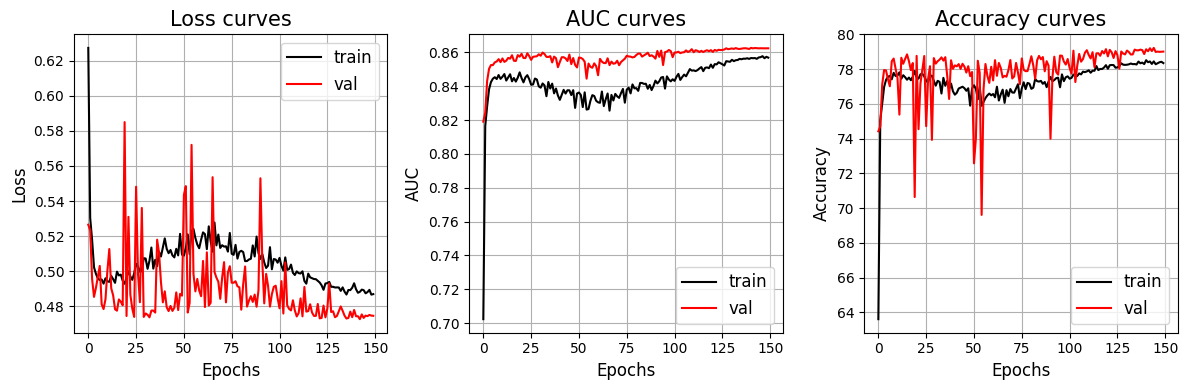

In [14]:
# Visualizing the loss and accuracy curves.
fig = plt.figure(figsize=(12, 4))

# Loss
plt.subplot(1, 3, 1)
plt.plot(history_train_loss,"k",label="train")
plt.plot(history_val_loss,"r",label="val")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Loss curves", fontsize=15)
plt.legend(fontsize=12)
plt.grid()


# AUC
plt.subplot(1, 3, 2)
plt.plot(history_train_auc,"k",label="train")
plt.plot(history_val_auc,"r",label="val")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("AUC", fontsize=12)
plt.title("AUC curves", fontsize=15)
plt.legend(fontsize=12)
plt.grid()

# Accuracy
plt.subplot(1, 3, 3)
plt.plot(history_train_acc,"k",label="train")
plt.plot(history_val_acc,"r",label="val")
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.title("Accuracy curves", fontsize=15)
plt.legend(fontsize=12)
plt.grid()
plt.tight_layout()
plt.show()

In [15]:
# Final Metrics:
model.load_state_dict(torch.load('GNNmodel_2.pth'))
train_loss, train_accuracy, train_auc = final_evaluation(model,train_loader)
val_loss, val_accuracy, val_auc= final_evaluation(model,val_loader)
test_loss, test_accuracy, test_auc= final_evaluation(model,test_loader)
clear_output()
print("The final losses and accuracies on the training, validation and test sets are as follows:")
print(f"Train | loss: {train_loss:.5f} | Accuracy: {train_accuracy:.3f}% | AUC: {train_auc:.5f}")
print(f"Val   | loss: {val_loss:.5f}   | Accuracy: {val_accuracy:.3f}%   | AUC: {val_auc:.5f}")
print(f"Test  | loss: {test_loss:.5f}  | Accuracy: {test_accuracy:.3f}%  | AUC: {test_auc:.5f}")

The final losses and accuracies on the training, validation and test sets are as follows:
Train | loss: 0.47512 | Accuracy: 79.146% | AUC: 0.86614
Val   | loss: 0.47342   | Accuracy: 79.227%   | AUC: 0.86245
Test  | loss: 0.47781  | Accuracy: 78.420%  | AUC: 0.85787


In [16]:
def plot_conf_matrix(model,test_loader):
    pred_list = []
    true_list = []
    model.eval()
    with torch.inference_mode():
        for data in test_loader:
            x, edge_index, batch_idx, y = data.x, data.edge_index, data.batch, data.y
            x, edge_index, batch_idx, y = x.to(device), edge_index.to(device), batch_idx.to(device), y.to(device)
            test_pred = model(x, edge_index, batch_idx)
            pred_list.append(test_pred.cpu().numpy())
            true_list.append(y.cpu().numpy())
            
    pred_list = (np.concatenate(pred_list,0).squeeze() >= 0).astype(int)
    true_list = np.concatenate(true_list,0)
    conf_matrix = confusion_matrix(true_list, pred_list)
    sns.set(font_scale=1.4)
    sns_hmp = sns.heatmap(conf_matrix, annot=True, fmt='d', annot_kws={"size": 16})
    fig = sns_hmp.get_figure()

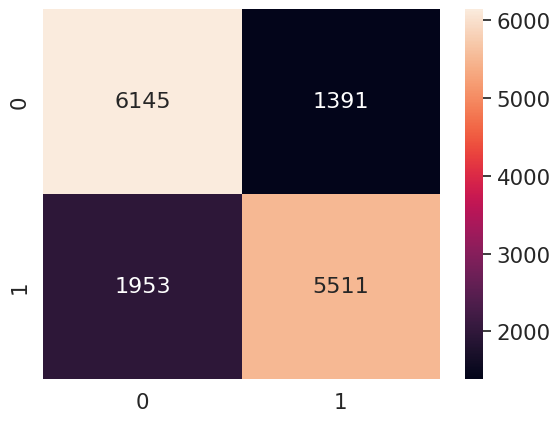

In [17]:
model = GraphGNNModel(c_in = dataset.num_node_features,c_hidden = 16, c_out=1, num_layers=2, layer_name="GAT").to(device)
model.load_state_dict(torch.load('GNNmodel_1.pth'))
plot_conf_matrix(model,test_loader)

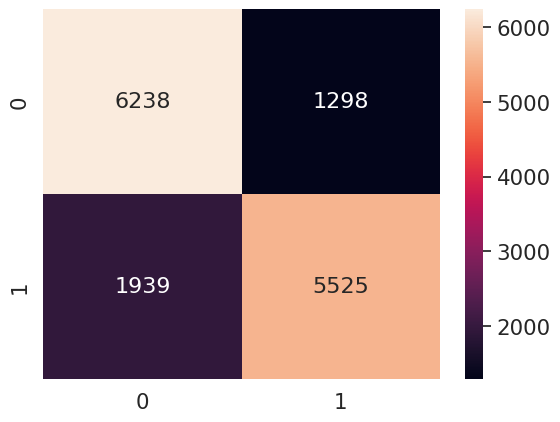

In [18]:
model = GraphGNNModel(c_in = dataset.num_node_features,c_hidden = 16, c_out=1, num_layers=2, layer_name="GATv2").to(device)
model.load_state_dict(torch.load('GNNmodel_2.pth'))
plot_conf_matrix(model,test_loader)

### Results:

Both models give an AUC of more than 0.85 each. But as proposed in the [literature](https://arxiv.org/abs/1810.05165) it can be taken to 0.90. I couldn't try a lot of hyperparameters given to my busy schdeule. 